In [4]:
#Install Required Libraries
#!pip install PyPDF2 spacy pandas numpy matplotlib seaborn scikit-learn sentence-transformers pytesseract pdf2image

# Install the SpaCy model
#!python -m spacy download en_core_web_sm
#!pip install wordcloud nltk

# Download WordNet data
#import nltk
#nltk.download('wordnet')
#nltk.download('omw-1.4')
#!pip install -U sentence-transformers
#!pip install shap

In [5]:
import numpy as np
import pandas as pd
import os
import PyPDF2
import pytesseract
import re
import spacy

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from wordcloud import WordCloud
from nltk.corpus import wordnet as wn
from collections import defaultdict
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import shap


### 1. Data Cleaning and Preparation

In [6]:
# Load metadata
metadata = pd.read_csv('/workspaces/project-2-ombudsman/metadata.csv')

# Set the directories
base_folders = [
    #'/workspaces/project-2-ombudsman/12_23_insurance',
    #'/workspaces/project-2-ombudsman/01_24_insurance',
    #'/workspaces/project-2-ombudsman/02_24_insurance',
    #'/workspaces/project-2-ombudsman/03_24_insurance',
    #'/workspaces/project-2-ombudsman/04_24_insurance',
    '/workspaces/project-2-ombudsman/05_24_insurance'
]

# Load spaCy model
nlp = spacy.load("en_core_web_sm")


In [7]:
# Function to get metadata info
def get_metadata_info(filename):
    decision_id = re.search(r'DRN-(\d+)', filename).group(1)
    row = metadata[metadata['decision_id'].str.contains(decision_id)]
    if not row.empty:
        decision = row.iloc[0]['decision']
        company = row.iloc[0]['company']
        return decision, company
    else:
        return None, None

**Exclude words**

# Expanded custom stop words list
text_exclude = set([
    "aa", "d", "g",
    "able", "account", "act", "action", "accept", "add", "address", "after","agree", "appear", "appeared", "apply", 
    "appreciate", "april", "august", "arrange", "are", "ask", "august", "available", 
    "base", "basis", "be", "been", "before", "begin", "believe", "behalf", "buy",
    "can", "case", "carry", "cause", "claim", "complain", "complains", "complaint", "complained","comment", "company", 
    "conclude", "conclusion", "concern", "consider", "continue", "could", "cost", "customer",
    "date", "day", "decide", "decision","decrease", "deduct", "december", "discuss", "direct", "does", "did", 
    "europe","event", "evidence","explain", "example", "existing", "end",
    "feel", "felt", "february", "final", "find", "finding", "first", "follow", "fully",
    "gave", "get", "give", "go", "going", "got", 
    "handle", "happen", "happened", "had", "has", "have", "hm","hours", "how", 
    "incident", "include", "increase", "indicate","initial", "insurance", "investigate", "investigator", "i.e.", "is", "issue", "item", 
    "january", "july", "june", "know", "knew", "later", "lead", "list", "like", "line", "likely", "limited", "Limited", "ltd", "Ltd", "look", "looked", 
    "main", "make", "made", "march", "matter", "may", "mean", "might", "minutes", "month", 
    "need", "new", "not uphold", "note", "november", "number", "october", "ombudsman", "overall",
    "ph", "photo", "perhaps", "policy", "place", "point", "position", "pre", "previous","prior", "provisional", "provide", "put", "question", 
    "reason", "receive", "record", "refer", "remain", "report", "request", "require", "result", "return", "right", 
    "sa","said", "saw", "say", "see", "second", "section", "seen", "send", "set", "september", 
    "shall", "should", "show", "simple","sorry","start", "summary", "sun",
    "take", "tell", "third","thing", "think", "thought", "time", "to", "told", "total", "took", "turn", "try",
    "uk","uphold","unable",  "use", "usually", "ultimately","vitality",
    "want", "way", "was", "went", "were", "week",
    "what", "when", "where", "which", "whilst", "why", "will", "work", "would", 
    "year"
])

In [16]:
# Function to get synonyms from WordNet
def get_synonyms(word):
    synonyms = set()
    for syn in wn.synsets(word):
        for l in syn.lemmas():
            synonyms.add(l.name().replace('_', ' ').lower())
    return synonyms

# Function to create synonym mapping for a list of words
def create_synonym_mapping(words):
    mapping = {}
    for word in words:
        synonyms = get_synonyms(word)
        representative = word  # You could also select the most common or central synonym
        for synonym in synonyms:
            mapping[synonym] = representative
    return mapping

# Generate synonym mapping for commonly important words in the domain
important_words = [
            'suggest', 'tax', 'impact', 'investment', 'commercial', 'document', 'transparent', 'circumtance'
]

synonym_mapping = create_synonym_mapping(important_words)

# Expanded custom stop words list
text_exclude = set([
    "aa", "d", "g",
    "april", "august",
    "december", 
    "europe", "event", 
     "february",
    "hm",
     "i.e.",
    "january", "july", "june", "limited", "Limited", "ltd", "Ltd", 
    "march", 
    "november", "number", "october", "ombudsman", "overall",
    "ph",
    "sa","september", 
    "sun",
    "uk"
])

complain_exclude = set([
    "ltd", "limited", "insurance", "services", "company", "plc", "uk", "group", "corporation", "assurance", 
    "association", "international", "general", "financial", "follow", "national", "union", "sun", "behalf",
    "mutual", "europe", "europe", "sa/nv", "se", "year", "month", "day","insurer",
    "january", "february", "march","april","may","june","july","august","september","october","november","december",
    "claim", "policy", "complain", "complains",  "complaint", "complained", "ph", "sa"
])

# Function to clean and replace synonyms in text, retaining sentence structure and auxiliary verbs
def clean_text_with_synonyms(text, synonym_mapping, excl_words):
    doc = nlp(text)
    tokens = [
        synonym_mapping.get(token.text.lower(), token.text.lower())  # Replace with synonym if available
        for token in doc
        if len(token.text) > 1  # Exclude single-character tokens
        and (token.is_alpha or token.is_punct)  # Keep only alphabetic tokens and meaningful punctuation
        and not re.match(r'^(mr|mrs|miss|ms)\.?$', token.text, re.IGNORECASE)  # Exclude common titles
        and token.text.lower() not in excl_words  # Exclude specific unwanted words
    ]
    return ' '.join(tokens)

**Extract the main complaint reason**

In [8]:
# Function to extract text from "The complaint" section
def extract_complaint_section(text):
    pattern = re.compile(r'The complaint.*?(?=What happened|Background|Findings|My final decision|Putting things right)', re.DOTALL)
    match = pattern.search(text)
    if match:
        return match.group(0)
    return None

# Function to extract main reason for the complaint
def extract_main_reason(text):
    doc = nlp(text)
    complaint_phrase = ""
    # Look for patterns indicating dissatisfaction
    for sent in doc.sents:
        if any(keyword in sent.text.lower() for keyword in ["complain", "complained", "complains", 
                                                            "unhappy", "disappointed", "not satisfied", "not happy", 
                                                            "dissatisfied", "dissatisfaction", "frustrated", "frustration"]):
            complaint_phrase = sent
            break

    # Extract the main reason in up to 30 words
    main_reason = []
    found_complaint = False
    for token in complaint_phrase:
        # Look for the pattern indicating the complaint reason
        if found_complaint:
            if token.dep_ in ("amod", "acomp", "attr", "dobj", "pobj", "advmod", "ROOT", "poss", "nsubj", "prep", "conj") and token.text.lower() not in {"complain",
                                                                                                    "unhappy", "disappointed", "that", "about"}:
                main_reason.append(token.text)
            if len(main_reason) >= 30:
                break
        if any(keyword in token.lemma_.lower() for keyword in ["complain", "complained", "complains", "feels",
                                                               "unhappy", "disappoint", "not happy", "not satisfied", "dissatisfied", "frustrated"]):
            found_complaint = True

    return ' '.join(main_reason[:30])

# Function to remove "The complaint" section from text
def remove_complaint_section(text):
    pattern = re.compile(r'The complaint.*?(?=What happened|Background|Findings|My final decision|Putting things right)', re.DOTALL)
    return pattern.sub('', text)

**Extract Compensation Amount**

In [15]:
# Function to extract compensation amount from "My final decision" or "Putting things right" sections
def extract_compensation(text):
    patterns = [
        re.compile(r'My final decision.*?(£[\d,]+(?:\.\d+)?)', re.DOTALL),
        re.compile(r'Putting things right.*?(£[\d,]+(?:\.\d+)?)', re.DOTALL)
    ]
    for pattern in patterns:
        match = pattern.search(text)
        if match:
            return match.group(1)
    return None

**Standardise company name and remove company name from the feature text**

In [14]:
# List of company names to remove
company_names = [
    "UKI", "AIA", "AIG", "247 Home Assist", "A plan holdings", "AA Underwriting", "Abacus", "Abbey", "Abbeyfields",
    "Acasta European", "Accelerant", "Accredited", "Acorn", "Acromas", "Action 365", "ActiveQuote", "ACUITY PROFESSIONAL ADVISERS",
    "Admiral", "Adrian Flux", "Advance", "Advance Mortgage", "Advantage", "Advisory", "Aetna", "Affinity", "Ageas", "Ageas Retail",
    "Agency Management Network", "Agria Pet", "AIG Life", "Aioi Nissay Dowa", "Alan Boswell", "Albany Park", "AllClear", 
    "Allianz Business", "Allianz Global Corporate", "Allianz", "Allied World Assurance", "Alwyn", "American Express",
    "American International Group", "Amicus", "Amtrust Europe", "Amtrust International", "Ancile", "Andrew Smith",
    "Animal Friends", "Aon", "Apex", "Apple Retail", "ARAG Allgemeine Versicherungs", "Arc Legal Assistance", "Arch", "Argos",
    "Arthur J. Gallagher", "Aspen", "Aspray", "Assicurazioni Generali", "Assurant Direct", "Assurant General", "Assured Futures",
    "Aston Lark", "Astrenska", "Asurion Europe", "ATLANTA 1", "Atlanta Insurance Intermediaries", "Atlas", "Automobile Association",
    "AutoProtect", "Avantia", "Aviva Health", "Aviva", "Aviva Life & Pensions", "Avon", "AWP P&C", "AXA Assistance", "AXA France IARD",
    "AXA Health", "AXA", "AXA PPP Healthcare", "AXA XL", "AXIS Specialty Europe", "Balens", "Bank of Scotland", "Bapchild Motoring World",
    "Barclays Bank", "Bartholomew & James", "Bastion", "BCR Legal Group", "Bennetts Motorcycling", "Berkshire Hathaway International",
    "Best Protect Online", "BISL", "Blue Badge Mobility", "BQI Group", "Bradford & Bingley", "Brightside", "British Friendly Society",
    "British Gas", "Broker Direct", "Broker Experts", "Brooklin Claims Consultants", "Bryan James & Co", "Building Block", "Bulstrad Life Vienna",
    "BUPA", "Business Insurance Solutions", "Butterworth Spengler Commercial", "Calpe", "Cambrian Associates", "Canada Life",
    "Capital One (Europe)", "Car Care Plan", "Card Protection Plan", "Carole Nash", "Carrot Risk Technologies", "CASLP", "Caspian Assured",
    "Castle Financial & Mortgage", "Casualty & General", "Cavendish Munro Professional Risks", "Cavendish Online", "Chalfont Investment Consultants",
    "Chaucer", "China Taiping", "Chubb European Group", "Cia", "Cigna Europe", "CIGNA Europe", "CIGNA Life", "CIP Brokers", "Cirencester Friendly Society",
    "City And Commercial", "Clear Insurance Management", "Clegg Gifford & Co", "Clements Europe", "Click2protect", "Close Asset Management",
    "Cogent", "Collingwood", "Collinson", "Compare The Market", "Complete Cover Group", "ComplianceTrak", "Connells", "Convex",
    "Co-op", "Cornish Mutual Assurance", "Countrywide Assured", "Countrywide Principal", "County Consultants", "Covea", "Coversure",
    "Coverwise", "Cowen", "Currys Group", "Cuvva", "DAS Legal Expenses", "Davies Craddock", "DAVIES MGA", "Deal Direct Financial Solutions",
    "Denis O Brown & Associates", "Devitt", "Domestic & General", "Dynamo Cover", "Ecclesiastical", "ERGO Reiseversicherung", "ERGO TRAVEL",
    "ERGO Versicherung", "Eridge Underwriting Agency", "Essential Finance Group Management", "esure", "Esure", "ETU Forsikring", "EUI",
    "Euler Hermes", "Euroins", "Europ Assistance", "Evolution", "Exchequer Risk Management", "Exeter Friendly Society", "Express Finance Corporation",
    "Extracover", "Fairmead", "Falcon Underwriting", "Finance Advice Group", "FinanceMe", "Financial & Legal", "Finch Commercial", "First Central Management",
    "First Central Underwriting", "First Complete", "First Title", "Fish Administration", "FMB", "FMG Support (FIM)", "Folgate", "Ford Retail",
    "Forsakringsaktiebolaget Agria", "Fortegra Europe", "Fox Private Finance", "Freeway UK", "Friends Capital", "Furniture Village", "Genistar",
    "Global Re Broking Solutions", "Goldcrest Ins", "Got You Covered", "Granite Finance", "Great Lakes", "Gresham", "Group 1 Automotive", "Grove & Dean",
    "H. W. Wood", "Halifax General", "Harris Balcombe", "Hastings", "Haven", "Hayburn Rock Financial Planning", "HCC International", "HDI Global",
    "Health and Protection", "Health Shield Friendly Society", "HEALTHCARE CLARITY", "Healthy Pets", "Heath Crawford", "Hedgehog", "Helvetia Global Solutions",
    "Herts Consultants", "HFIS", "Highway", "Higos", "Hiscox", "Hiscox Underwriting", "HMCA", "HMCA/S", "Holiday Extras Cover", "Homepro", "Homeserve Membership",
    "Hood Group", "Howden Employee Benefits & Wellbeing", "Howden Brokers","HSBC", "HSB Engineering", "HSBC Life", "HSBC Bank", "Hubener Versicherungs", "Hugh J. Boswell",
    "Hyperformance", "I Go 4", "I.M.S. (London)", "Impact Services (Bolton)", "Independent Health Care Solutions", "Inspop.com", "Claims Centre", "Insurance Factory",
    "Insure & Go", "INSURE GROUP", "Intelligent Advisory", "Inter Partner Assistance", "IPA SA", "International General", "IPP Financial Services", "Irwell", "ITC Compliance",
    "JCT600 (Yorkshire)", "Jelf Brokers", "Jigsaw", "John Henshall", "John Lewis", "John Robert Cox", "Kent and Sussex Financial Group", "Kerland Pitman", "KGM Underwriting",
    "Kingsbridge Risk Solutions", "Kingsway", "Kingswood Brokers", "Konsileo (Trading)", "L J J Associates", "Lakes Mortgages", "Legal and General Assurance Society",
    "Liberty Mutual", "Liberty Seguros", "Lifesearch Partners", "Lifetime Protection", "Lighthouse Advisory", "Liverpool Victoria Financial", "Liverpool Victoria",
    "Lloyd & Whyte Community Broking", "Lloyd & Whyte", "Lloyd", "Lloyds", "Lloyds Bank General", "Lloyds Bank", "Lloyd's", "Lockton Companies", "London and Country Mortgages", "London General",
    "Loyal", "LV", "M & D H", "M & N Service", "Magus Private Wealth", "Makesure", "ManyPets", "Mapfre Asistencia", "Markel International", "Markerstudy", "Marsh", "Marshall Motor",
    "Marshmallow Financial", "Marshmallow", "MBNA", "MCE", "McMorrow Murphy", "Medicash Health Benefits", "Mercedes-Benz Services", "Mercedes-Benz Retail", "Mercer", "MetLife Europe",
    "Michael Howard", "Mid Cornwall Brokers", "Midway", "Moneysupermarket.com Financial Group", "Monument Life", "Morgan Clark", "Mortgage Advice Bureau (Derby)", "Mortgage Advice Bureau",
    "Mortgage Connect (N.I)", "Morton Michel", "MotoNovo Finance", "Motor Gap", "Motorplus", "Motorpoint", "Motors", "MS Amlin", "Mudhut Property", "Mulsanne", "My Policy",
    "National Deposit Friendly Society", "National House-Building Council", "National Westminster Bank", "Nationwide Building Society", "Neilson Financial", "Nelson", "Newline", 
    "Next Risk Solutions", "Oakleafe Group", "Ocaso", "One Broker (Norwich)", "One Call", "One Insurance", "One Sure", "Openwork", "OVO (S) HOME", "P J Hayman & Company", "Paymentshield",
    "PEBBLE PROTECTION", "Pendragon Finance", "Peninsula Business", "People's Administration", "Personal Assurance", "Personal Touch", "Pet Protect", "Phoenix Life Assurance", "Phoenix Life",
    "PIB Risk", "Pinnacle", "Plum Underwriting", "POLICY EXCESS INSURE", "PolicyBee", "Policywave", "Post Office Management", "Premier Centre", "Premier", "Premier Plus", "Premier Underwriting",
    "Premium Choice", "Premium Credit", "Protector UK", "Pukka Insure", "QBE Europe", "QBE UK", "QIC Europe", "Qmetric Group", "Quilter Financial", "Quilter Mortgage Planning", "Quilter Wealth",
    "RAC Financial", "RAC", "Ramasis", "Reach Financial", "ReAssure Life", "ReAssure", "Reassured", "Red Sands", "Rentokil", "Revolut Travel", "Richmond Cars (Botley)", "Right Choice Brokers", 
    "Right to Health", "Ringsite", "Riverdale Business", "RiverStone", "Rock Services", "Royal & Sun Alliance","RSA", "S & L Healthcare", "Sabre", "Safe World", "Saga", "Sainsbury's Bank", 
    "Santander", "Sainsbury", "Scottish Equitable", "Scottish Friendly Assurance", "Scottish Widows", "SEIB BROKERS", "Sennocke International", "Sesame", "Simplyhealth Access", "Skyfire", "Society of Lloyd's",
    "Somerset Bridge Services", "Soteria", "St Andrew's", "St Giles and Finance", "St James's Place", "ST&R", "Starr International (Europe)", "Stonebridge International", "Stride",
    "Sun Life Assurance Company of Canada", "Sure Wise", "Suttons Independent Advisers", "Switch Health", "T&R Direct", "Taylormade Finance", "TBO", "Tedaisy Underwriting", 
    "Telefonica Seguros y Reaseguros", "Telefonica", "Telford-Reede", "Tempcover", "Tesco Mobile", "Tesco Personal Finance", "Tesco Underwriting", "Thamesbank", "Thatched Owners", 
    "The Ancient Order of Foresters Friendly", "The Baptist", "The Baxendale", "The Clear Health", "The Co-operative Bank", "The Equine and Livestock", "The National Farmers' Union Mutual",
    "The New India Assurance", "The Original Holloway Friendly", "The Plan Group", "The Prudential Assurance", "The Right Mortgage", "The Royal Bank of Scotland", "Royal London", 
    "The Salvation Army General", "The Shepherds Friendly", "Think Brokers", "Thistle Brokers", "Thomas Carroll (Brokers)", "TICORP", "Tokio Marine Kiln", "Tower Brokers", "Toyota (GB)",
    "Toyota Management", "Tradex", "Travel Facilities", "Travelers", "Tremellen Jeffrey Allan", "Trinity", "Trinity Lane", "U Drive Cover", "U K", "UIA", "Uinsure Commercial", "Uinsure", 
    "UK General", "Union Reiseversicherung", "Unique", "UNUM", "Urban Jungle", "Usay Business", "Utmost Life and Pensions", "V. Woodcock And", "Vantage IB", "Vitality Corporate", 
    "Vitality Health", "Vitality Life", "Vodafone", "Volkswagen Versicherung", "Voyager", "W Denis Brokers", "W E Bedford (Wimbledon)", "W Todd & Son", "Wakam", "Waltons Brokers", 
    "Warranty Management", "Warranty", "Watches of Switzerland", "Watford", "WDP", "Well Dunn", "Wesleyan Assurance Society", "West Bay", "Western Provident", "Westfield Contributory",
    "White Horse Ireland", "White Rose Solutions", "Whitefield Services", "William Russell", "Wilson", "Wise One", "Wrisk Transfer", "Xbridge", "Yachtline", "Yoga", "Zurich Assurance", 
    "Zurich"
]
# Function to standardize company name with standard abbreviations
def standardize_company_name(company):
    # List of words to remove
    words_to_remove = ["Ltd", "ltd", "limited", "Limited", "Insurance", "Services", "Company", "Plc", "UK", "U.K.", "Group", "Corporation", "Assurance", 
                       "Association", "International", "General", "Financial", "National", "Union", 
                       "Mutual", "Europe", "Europe SA/NV", "Europe SA", "Europe NV", "Europe SE", "dac", "SE", "NV"]

    # Standard abbreviations mapping
    abbreviations = {
        "AXA Insurance UK Plc": "AXA", "Allianz Insurance Plc": "Allianz", "Barclays Insurance": "Barclays",
        "Co-op Insurance": "Co-op", "Covea Insurance": "Covea", "Chubb Insurance": "Chubb", "Churchill Insurance": "Churchill",
        "Direct Line Insurance Group Plc": "Direct Line", "HSBC Insurance": "HSBC", "John Lewis Insurance": "John Lewis",
        "Legal & General Insurance": "Legal & General", "Lloyds Bank Insurance": "Lloyds Bank", "LV Insurance": "LV=",
        "Markerstudy Insurance": "Markerstudy","Nationwide Insurance": "Nationwide", "Royal & Sun Alliance Insurance" : "RSA",
        "Saga Insurance": "Saga", "Santander Insurance": "Santander", "Swinton Insurance": "Swinton", "Sainsbury's Insurance": "Sainsbury",
        "Tesco Bank Insurance": "Tesco Bank", "Virgin Money Insurance": "Virgin Money",
        "U K Insurance" : "U K","Zurich Insurance Plc": "Zurich"
        # Add other standard abbreviations as needed
    }

    # Remove the words_to_remove from the company name
    pattern = re.compile(r'\b(' + '|'.join(words_to_remove) + r')\b', re.IGNORECASE)
    standardized_name = pattern.sub('', company).strip()
    
    # Apply abbreviations
    if standardized_name in abbreviations:
        standardized_name = abbreviations[standardized_name]
    
    return standardized_name

# Remove company names from text
def remove_company_names(text, company_names):
    for company in company_names:
        company_standardized = standardize_company_name(company)
        text = re.sub(re.escape(company_standardized), '', text, flags=re.IGNORECASE)
    return text

#### 2. Natural Language Processing for Data Extraction: 

Textual data needs to be further
analysed to extract relevant information from each document, the data extracted can be
used as features for a downstream modelling task.

#### Step 1: Extract the original text from each PDF and save it in a DataFrame

In [12]:

# Function to extract text with PyPDF2
def extract_text_with_pypdf2(file_path):
    text = ''
    try:
        with open(file_path, 'rb') as file:
            reader = PyPDF2.PdfReader(file)
            for page_num in range(len(reader.pages)):
                page_text = reader.pages[page_num].extract_text()
                if page_text:
                    text += page_text
    except Exception as e:
        print(f"Failed to extract text from {file_path} using PyPDF2: {e}")
    return text

# Extract text from all PDFs in specified directories
def extract_text_from_pdfs(base_folders):
    pdf_texts = {}
    for base_folder in base_folders:
        for root, dirs, files in os.walk(base_folder):
            for filename in files:
                if filename.endswith('.pdf'):
                    file_path = os.path.join(root, filename)
                    text = extract_text_with_pypdf2(file_path)
                    pdf_texts[filename] = text
                    print(f"Extracted text from {filename}")
    return pdf_texts

pdf_texts = extract_text_from_pdfs(base_folders)

# Create a DataFrame with the extracted text
df = pd.DataFrame(list(pdf_texts.items()), columns=['filename', 'original_text'])

df.head(5)


Extracted text from 05_24_Insurance_DRN-4742637.pdf
Extracted text from 05_24_Insurance_DRN-4799770.pdf
Extracted text from 05_24_Insurance_DRN-4765620.pdf
Extracted text from 05_24_Insurance_DRN-4676443.pdf
Extracted text from 05_24_Insurance_DRN-4745742.pdf
Extracted text from 05_24_Insurance_DRN-4716398.pdf
Extracted text from 05_24_Insurance_DRN-4782302.pdf
Extracted text from 05_24_Insurance_DRN-4727954.pdf
Extracted text from 05_24_Insurance_DRN-4797239.pdf
Extracted text from 05_24_Insurance_DRN-4705246.pdf
Extracted text from 05_24_Insurance_DRN-4705244.pdf
Extracted text from 05_24_Insurance_DRN-4661546.pdf
Extracted text from 05_24_Insurance_DRN-4777311.pdf
Extracted text from 05_24_Insurance_DRN-4707248.pdf
Extracted text from 05_24_Insurance_DRN-4793790.pdf
Extracted text from 05_24_Insurance_DRN-4694864.pdf
Extracted text from 05_24_Insurance_DRN-4715662.pdf
Extracted text from 05_24_Insurance_DRN-4697952.pdf
Extracted text from 05_24_Insurance_DRN-4805137.pdf
Extracted te

,filename,original_text
0,05_24_Insurance_DRN-4742637.pdf,DRN-4742637\nThe complaint\nMrs K’s complaint ...
1,05_24_Insurance_DRN-4799770.pdf,"DRN-4799770\nThe complaint\nMr R, Mrs W and Mi..."
2,05_24_Insurance_DRN-4765620.pdf,DRN-4765620\nThe complaint\nMr E complains Her...
3,05_24_Insurance_DRN-4676443.pdf,DRN-4676443\nThe complaint\nMr and Mrs S’ comp...
4,05_24_Insurance_DRN-4745742.pdf,DRN-4745742\nThe complaint\nMiss T complains t...


In [ ]:
# Select only the 'original_text' and 'filename' columns
#df_to_save = df[['filename', 'original_text']]

# Save the selected columns to a CSV file
#df_to_save.to_csv('ori_text.csv', index=False)

#df = pd.read_csv('/workspaces/project-2-ombudsman/ori_text.csv')


In [10]:
# Generate word clouds
def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

#### Step 2a: Extract only the complaint section and get the main reason

In [17]:
# Apply extraction functions to the DataFrame
df['complaint_section'] = df['original_text'].apply(extract_complaint_section)
df['main_reason'] = df['complaint_section'].apply(extract_main_reason)

# Clean the main reason text
df['main_reason'] = df['main_reason'].apply(lambda x: clean_text_with_synonyms(x, synonym_mapping, complain_exclude) if x else None)


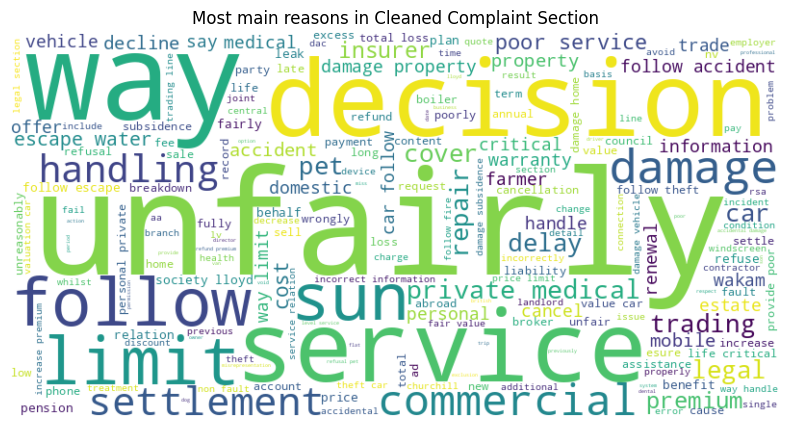

In [ ]:
generate_word_cloud(' '.join(df['main_reason'].dropna()), 'Most main reasons in Cleaned Complaint Section')

#### Step 2b: Extract the complaint section plus what happened section

In [18]:
def extract_complaint_and_what_happened_section(text):
    # Define the patterns to locate the complaint and what happened sections
    complaint_pattern = re.compile(r'The complaint(.*?)What happened', re.DOTALL)
    what_happened_pattern = re.compile(r'What happened(.*?)(What I’ve decided – and why|My final decision|The investigator’s view|My provisional decision|Putting things right)', re.DOTALL)
    
    # Extract the complaint section
    complaint_match = complaint_pattern.search(text)
    complaint_section = complaint_match.group(1).strip() if complaint_match else ''

    # Extract the what happened section
    what_happened_match = what_happened_pattern.search(text)
    what_happened_section = what_happened_match.group(1).strip() if what_happened_match else ''
    
    # Combine the extracted sections into one string
    combined_section = complaint_section + ' ' + what_happened_section
    return combined_section

# Apply the function to extract combined sections and add it as a new column
df['complaint_and_what_happened'] = df['original_text'].apply(extract_complaint_and_what_happened_section)
#generate_word_cloud(' '.join(df['complaint_and_what_happened'].dropna()), 'Most Common Words in Original text in complaint & what happened section')

#### Step 3: Investigate the most common words by the word cloud, cleaning the extracted text from Step 2a and 2b

In [19]:
# Clean the extracted sections
df['clean_complain_n_what_happen'] = df['complaint_and_what_happened'].apply(lambda x: clean_text_with_synonyms(x, synonym_mapping, text_exclude) if x else None)
#generate_word_cloud(' '.join(df['clean_complain_n_what_happen'].dropna()), 'Most Common Words in cleaned complaint and what happened section')

df['cleaned_text'] = df['clean_complain_n_what_happen'].apply(lambda x: remove_company_names(x, company_names) if x else None)
#generate_word_cloud(' '.join(df['cleaned_text'].dropna()), 'Most Common Words after cleaning and remove company names in complaint and what happened section')

In [20]:
df.head()

,filename,original_text,complaint_section,main_reason,complaint_and_what_happened,clean_complain_n_what_happen,cleaned_text
0,05_24_Insurance_DRN-4742637.pdf,DRN-4742637\nThe complaint\nMrs K’s complaint ...,The complaint\nMrs K’s complaint is about a cl...,is she on her legal,Mrs K’s complaint is about a claim she made on...,complaint is about claim she made on her one i...,complaint is about claim she made on her insu...
1,05_24_Insurance_DRN-4799770.pdf,"DRN-4799770\nThe complaint\nMr R, Mrs W and Mi...","The complaint\nMr R, Mrs W and Miss W complain...",ad handling of their,"Mr R, Mrs W and Miss W complain about Euroins ...",and complain about euroins ad handling of thei...,and complain about ad handling of their trave...
2,05_24_Insurance_DRN-4765620.pdf,DRN-4765620\nThe complaint\nMr E complains Her...,The complaint\nMr E complains Herts Insurance ...,trading unfairly his after payment on agreed date,Mr E complains Herts Insurance Consultants Ltd...,complains herts insurance consultants trading ...,complains herts insurance consultants trading ...
3,05_24_Insurance_DRN-4676443.pdf,DRN-4676443\nThe complaint\nMr and Mrs S’ comp...,The complaint\nMr and Mrs S’ complaint is abou...,is handling of they on their,Mr and Mrs S’ complaint is about the handling ...,and complaint is about the handling of claim t...,and complaint is about the handling of claim t...
4,05_24_Insurance_DRN-4745742.pdf,DRN-4745742\nThe complaint\nMiss T complains t...,The complaint\nMiss T complains that Advantage...,for damage she it on her discount under her,Miss T complains that Advantage Insurance Comp...,complains that advantage insurance company adv...,complains that insurance company progressed ...


#### Adding decision and company columns to the DataFrame

In [21]:
# Adding decision and company columns to the DataFrame
def add_decision_and_company_info(df, metadata):
    decisions = []
    companies = []
    for filename in df['filename']:
        decision, company = get_metadata_info(filename)
        decisions.append(decision)
        companies.append(standardize_company_name(company))
    
    df['decision'] = decisions
    df['company'] = companies

    # Remove blank brackets () from company names
    df['company'] = df['company'].str.replace(r'\(\s*\)', '', regex=True).str.strip()

    return df

# Apply the function to add decision and company info to the DataFrame
df = add_decision_and_company_info(df, metadata)

### Extract Product Type

In [22]:
# Known product types for insurance
known_products = {
    'property': r'(property owners|property insurance|home insurance|home emergency|land|house)',
    'buildings': r'(buildings|buildings and contents|flat|apartment)',
    'machine and electronics': r'(appliances|washing machine)',
    'car': r'(car insurance|motor|vehicle)',
    'travel': r'(travel|trip)',
    'health': r'(health|healthcare|disease|medical|private medical|surgery|hospital)',
    'life': r'(life|life insurance|life policy|life protection)',
    'pet': r'(pet|dog|petwise|animal)',
    'business': r'(business insurance|business interruption|business)', 
    'income': r'(income|income protection|income insurance)',
    'boiler': r'boiler',
    'wedding': r'(wedding|wedding insurance)',
    'emergency': r'(emergency insurance|emergency protection|emergency warranty)',
    'legal expenses': r'(legal advice|legal expenses|legal expense)',
    'ppi' : r'(payment protection insurance|ppi)',
    'others':r'(home|property|burglary)',
}

# Function to extract product type from text
def extract_product_type(text):
    product_types = set()

    # Check for known product types first
    for product, pattern in known_products.items():
        if re.search(pattern, text, re.IGNORECASE):
            product_types.add(product)

    # If multiple product types are detected, return the first match for simplicity
    if len(product_types) > 1:
        product_types = {list(product_types)[0]}
    
    return ', '.join(product_types) if product_types else 'Unknown'

# Example synonym mapping
synonym_mapping = {
    "insurance": "insurance",
    "warranty": "insurance",
    "guarantee": "insurance",
}

# Exclusion set for cleaning text
exclude = set(["claim", "policy", "complain", "complains",  "complaint", "complained", "company", "brokers", "decline", "reference",
               "period", "cover", "follow", "service"])

df['clean_complaint'] = df['complaint_section'].apply(lambda x: clean_text_with_synonyms(x, synonym_mapping, exclude))
# Apply the extract_product_type function to the DataFrame
df['product_type'] = df['clean_complaint'].apply(extract_product_type)

# Define a function to re-extract product type from cleaned text if initial extraction is 'Unknown'
def re_extract_product_type(row):
    if row['product_type'] == 'Unknown':
        return extract_product_type(row['cleaned_text'])
    return row['product_type']

# Apply the re-extraction function
df['product_type'] = df.apply(re_extract_product_type, axis=1)

# Count occurrences of each product type
product_type_counts = df['product_type'].value_counts()

# Display the counts
print(product_type_counts)

product_type
car                        114
property                    79
travel                      44
buildings                   25
health                      20
pet                         18
life                        17
Unknown                     14
legal expenses              11
others                      11
income                       6
business                     6
ppi                          4
boiler                       2
machine and electronics      1
Name: count, dtype: int64


In [23]:
df.head()

,filename,original_text,complaint_section,main_reason,complaint_and_what_happened,clean_complain_n_what_happen,cleaned_text,decision,company,clean_complaint,product_type
0,05_24_Insurance_DRN-4742637.pdf,DRN-4742637\nThe complaint\nMrs K’s complaint ...,The complaint\nMrs K’s complaint is about a cl...,is she on her legal,Mrs K’s complaint is about a claim she made on...,complaint is about claim she made on her one i...,complaint is about claim she made on her insu...,Not upheld,One,the is about she made on her one insurance lim...,legal expenses
1,05_24_Insurance_DRN-4799770.pdf,"DRN-4799770\nThe complaint\nMr R, Mrs W and Mi...","The complaint\nMr R, Mrs W and Miss W complain...",ad handling of their,"Mr R, Mrs W and Miss W complain about Euroins ...",and complain about euroins ad handling of thei...,and complain about ad handling of their trave...,Not upheld,Euroins AD,the and about euroins ad handling of their tra...,travel
2,05_24_Insurance_DRN-4765620.pdf,DRN-4765620\nThe complaint\nMr E complains Her...,The complaint\nMr E complains Herts Insurance ...,trading unfairly his after payment on agreed date,Mr E complains Herts Insurance Consultants Ltd...,complains herts insurance consultants trading ...,complains herts insurance consultants trading ...,Not upheld,Herts Consultants,the herts insurance consultants ltd trading as...,car
3,05_24_Insurance_DRN-4676443.pdf,DRN-4676443\nThe complaint\nMr and Mrs S’ comp...,The complaint\nMr and Mrs S’ complaint is abou...,is handling of they on their,Mr and Mrs S’ complaint is about the handling ...,and complaint is about the handling of claim t...,and complaint is about the handling of claim t...,Not upheld,DAS Legal Expenses,the and is about the handling of they made on ...,legal expenses
4,05_24_Insurance_DRN-4745742.pdf,DRN-4745742\nThe complaint\nMiss T complains t...,The complaint\nMiss T complains that Advantage...,for damage she it on her discount under her,Miss T complains that Advantage Insurance Comp...,complains that advantage insurance company adv...,complains that insurance company progressed ...,Upheld,Advantage,the that advantage insurance limited advantage...,car


### Splitting Data Into Training and Testing  

In [24]:
# Split the data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [25]:

# Load the paraphrase-mpnet-base-v2 model 'paraphrase-mpnet-base-v2'
model = SentenceTransformer('all-mpnet-base-v2')

# Generate embeddings
emb_train = model.encode(train_df['cleaned_text'].tolist(), convert_to_tensor=True)

# Optional: Convert embeddings to numpy array for further processing
emb_train_np = emb_train.cpu().numpy()

# Example: Printing the shape of the embeddings to verify
print(emb_train_np.shape)

# Save the embeddings to a .npy file
np.save('embed_train_0524.npy', emb_train_np)

: 

In [15]:

# Load the embeddings from the .npy file
# embeddings_numpy = np.load('embed_vectors.npy')

In [19]:
# Generate embeddings for test data
emb_test = model.encode(test_df['cleaned_text'].tolist(), convert_to_tensor=True)

# Optional: Convert embeddings to numpy array for further processing
emb_test_np = emb_test.cpu().numpy()

# Example: Printing the shape of the embeddings to verify
print(emb_test_np.shape)

# Save the embeddings to a .npy file
np.save('embed__test_0524.npy', emb_test_np)

(75, 768)


In [20]:
# Vectorize the text data
#vectorizer = TfidfVectorizer(max_features=1000)
#X = vectorizer.fit_transform(df['cleaned_text'])
X_train = emb_train_np
y_train = train_df['decision']
X_test = emb_test_np
y_test = test_df['decision']

# Train-test split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'X_train shape : {X_train.shape}')
print(f'X_test shape :{X_test.shape}')
print(f'y_train shape : {y_train.shape}')
print(f'y_test shape : {y_test.shape}')

X_train shape : (297, 768)
X_test shape :(75, 768)
y_train shape : (297,)
y_test shape : (75,)


### Explore y_train and X_train

Label distribution in training data:
 decision
Not upheld    158
Upheld        139
Name: count, dtype: int64


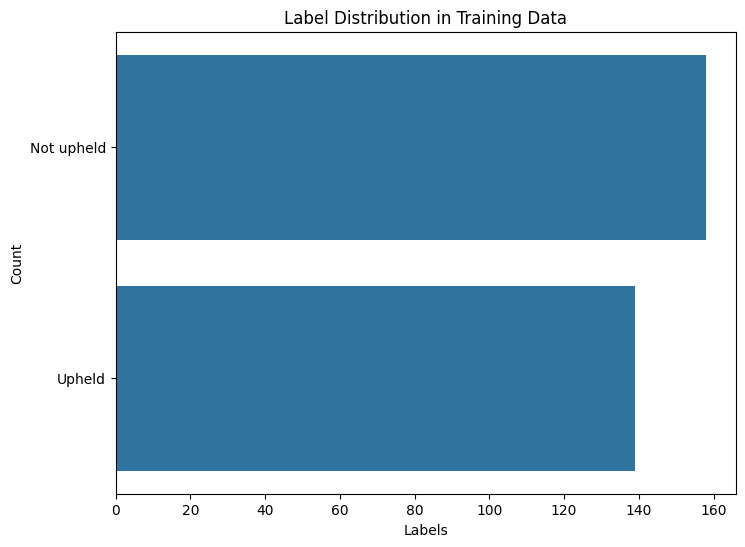

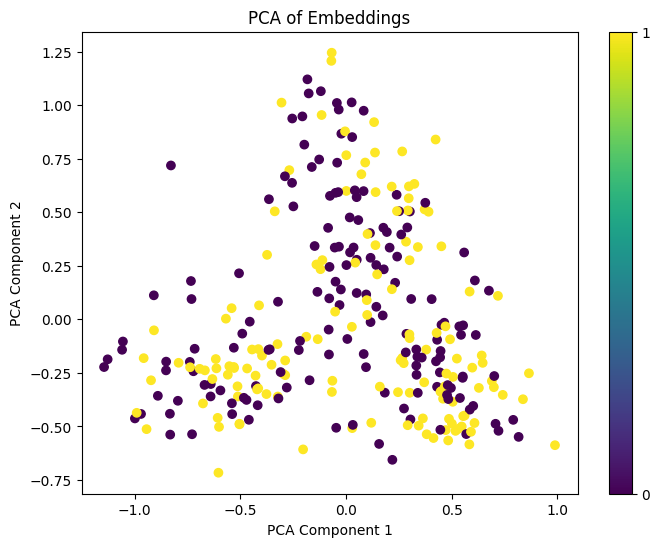

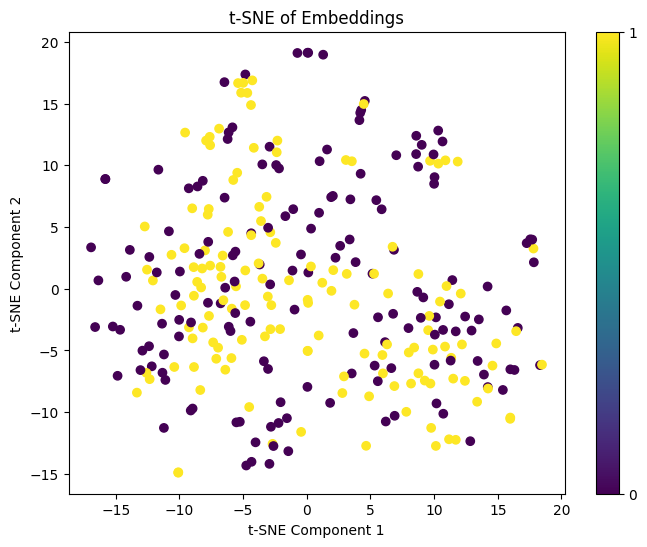

Missing values in X_train: 0
Missing values in y_train: 0


In [21]:
# Encode the labels to numeric values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# 1. Check the distribution of the labels
label_counts = y_train.value_counts()
print("Label distribution in training data:\n", label_counts)

# Plot the label distribution
plt.figure(figsize=(8, 6))
sns.countplot(y_train)
plt.title("Label Distribution in Training Data")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.show()

# 2. Visualize the embedding distributions
# PCA for 2D visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

# Plot PCA result
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_encoded, cmap='viridis')
plt.colorbar(scatter, ticks=range(len(label_counts)))
plt.title("PCA of Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# t-SNE for 2D visualization (this can take some time)
tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train)

# Plot t-SNE result
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train_encoded, cmap='viridis')
plt.colorbar(scatter, ticks=range(len(label_counts)))
plt.title("t-SNE of Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

# 3. Check for missing values
missing_values_X_train = np.sum(np.isnan(X_train))
missing_values_y_train = np.sum(pd.isnull(y_train))
print(f"Missing values in X_train: {missing_values_X_train}")
print(f"Missing values in y_train: {missing_values_y_train}")

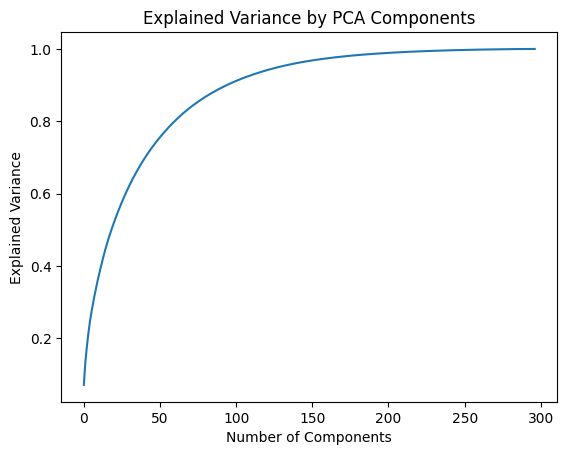

In [20]:
pca = PCA()
pca.fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.show()

In [19]:
from sklearn.decomposition import PCA

# Let's assume we want to capture 95% of the variance
pca = PCA(n_components=0.95)  # 0.95 means we want 95% variance
X_train_OptDim = pca.fit_transform(X_train)

# Transform the test set as well
X_test_OptDim = pca.transform(X_test)

# Check the shape of the reduced data
print(f"Reduced X_train shape: {X_train_OptDim.shape}")
print(f"Reduced X_test shape: {X_test_OptDim.shape}")


Reduced X_train shape: (2784, 165)
Reduced X_test shape: (697, 165)


### Modelling : Logistic Regression

In [29]:
# Hyperparameter tuning for Logistic Regression
param_grid_lr = {'C': [0.01, 0.03, 0.05, 0.1, 0.5, 1, 10], 'max_iter' : [5,10, 20, 50, 100]}
grid_lr = GridSearchCV(LogisticRegression(), param_grid_lr, refit=True, verbose=2)
grid_lr.fit(X_train, y_train)

Fitting 5 folds for each of 35 candidates, totalling 175 fits
[CV] END .................................C=0.01, max_iter=5; total time=   0.0s
[CV] END .................................C=0.01, max_iter=5; total time=   0.0s
[CV] END .................................C=0.01, max_iter=5; total time=   0.0s
[CV] END .................................C=0.01, max_iter=5; total time=   0.0s
[CV] END .................................C=0.01, max_iter=5; total time=   0.0s
[CV] END ................................C=0.01, max_iter=10; total time=   0.0s
[CV] END ................................C=0.01, max_iter=10; total time=   0.0s
[CV] END ................................C=0.01, max_iter=10; total time=   0.0s
[CV] END ................................C=0.01, max_iter=10; total time=   0.0s
[CV] END ................................C=0.01, max_iter=10; total time=   0.0s
[CV] END ................................C=0.01, max_iter=20; total time=   0.0s
[CV] END ................................C=0.01

/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

[CV] END ................................C=0.03, max_iter=10; total time=   0.0s
[CV] END ................................C=0.03, max_iter=10; total time=   0.0s
[CV] END ................................C=0.03, max_iter=10; total time=   0.0s
[CV] END ................................C=0.03, max_iter=10; total time=   0.0s
[CV] END ................................C=0.03, max_iter=10; total time=   0.0s
[CV] END ................................C=0.03, max_iter=20; total time=   0.0s
[CV] END ................................C=0.03, max_iter=20; total time=   0.0s
[CV] END ................................C=0.03, max_iter=20; total time=   0.0s
[CV] END ................................C=0.03, max_iter=20; total time=   0.0s
[CV] END ................................C=0.03, max_iter=20; total time=   0.0s
[CV] END ................................C=0.03, max_iter=50; total time=   0.0s
[CV] END ................................C=0.03, max_iter=50; total time=   0.0s
[CV] END ...................

/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

[CV] END ................................C=0.05, max_iter=50; total time=   0.0s
[CV] END ................................C=0.05, max_iter=50; total time=   0.0s
[CV] END ................................C=0.05, max_iter=50; total time=   0.0s
[CV] END ................................C=0.05, max_iter=50; total time=   0.0s
[CV] END ...............................C=0.05, max_iter=100; total time=   0.0s
[CV] END ...............................C=0.05, max_iter=100; total time=   0.0s
[CV] END ...............................C=0.05, max_iter=100; total time=   0.0s
[CV] END ...............................C=0.05, max_iter=100; total time=   0.0s
[CV] END ...............................C=0.05, max_iter=100; total time=   0.0s
[CV] END ..................................C=0.1, max_iter=5; total time=   0.0s
[CV] END ..................................C=0.1, max_iter=5; total time=   0.0s
[CV] END ..................................C=0.1, max_iter=5; total time=   0.0s
[CV] END ...................

/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

[CV] END ...................................C=1, max_iter=10; total time=   0.0s
[CV] END ...................................C=1, max_iter=10; total time=   0.0s
[CV] END ...................................C=1, max_iter=10; total time=   0.0s
[CV] END ...................................C=1, max_iter=10; total time=   0.0s
[CV] END ...................................C=1, max_iter=20; total time=   0.0s
[CV] END ...................................C=1, max_iter=20; total time=   0.0s
[CV] END ...................................C=1, max_iter=20; total time=   0.0s
[CV] END ...................................C=1, max_iter=20; total time=   0.0s
[CV] END ...................................C=1, max_iter=20; total time=   0.0s
[CV] END ...................................C=1, max_iter=50; total time=   0.0s
[CV] END ...................................C=1, max_iter=50; total time=   0.0s
[CV] END ...................................C=1, max_iter=50; total time=   0.0s
[CV] END ...................

/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

[CV] END ..................................C=10, max_iter=10; total time=   0.0s
[CV] END ..................................C=10, max_iter=10; total time=   0.0s
[CV] END ..................................C=10, max_iter=20; total time=   0.0s
[CV] END ..................................C=10, max_iter=20; total time=   0.0s
[CV] END ..................................C=10, max_iter=20; total time=   0.0s
[CV] END ..................................C=10, max_iter=20; total time=   0.0s
[CV] END ..................................C=10, max_iter=20; total time=   0.0s
[CV] END ..................................C=10, max_iter=50; total time=   0.0s
[CV] END ..................................C=10, max_iter=50; total time=   0.0s
[CV] END ..................................C=10, max_iter=50; total time=   0.0s
[CV] END ..................................C=10, max_iter=50; total time=   0.0s
[CV] END ..................................C=10, max_iter=50; total time=   0.0s
[CV] END ...................

/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.03, 0.05, 0.1, 0.5, 1, 10],
                         'max_iter': [5, 10, 20, 50, 100]},
             verbose=2)

In [30]:
# Best parameters from GridSearchCV for Logistic Regression
print("Best parameters for Logistic Regression:", grid_lr.best_params_)

# Predictions and evaluation for Logistic Regression
y_pred_lr = grid_lr.predict(X_test)
print("Logistic Regression Classifier:")
print(classification_report(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))

Best parameters for Logistic Regression: {'C': 0.05, 'max_iter': 5}
Logistic Regression Classifier:
              precision    recall  f1-score   support

  Not upheld       0.58      0.83      0.68        36
      Upheld       0.74      0.44      0.55        39

    accuracy                           0.63        75
   macro avg       0.66      0.63      0.62        75
weighted avg       0.66      0.63      0.61        75

[[30  6]
 [22 17]]


### Modelling : Decision Tree

In [36]:
# Hyperparameter tuning for Decision Tree
param_grid_dt = {'criterion': ['gini', 'entropy'], 'max_depth': [2, 10, 15, 20], 'min_samples_split': [2 ,3, 4, 5, 6]}
grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, refit=True, verbose=2)
grid_dt.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END ...criterion=gini, max_depth=2, min_samples_split=2; total time=   0.0s
[CV] END ...criterion=gini, max_depth=2, min_samples_split=2; total time=   0.0s
[CV] END ...criterion=gini, max_depth=2, min_samples_split=2; total time=   0.0s
[CV] END ...criterion=gini, max_depth=2, min_samples_split=2; total time=   0.0s
[CV] END ...criterion=gini, max_depth=2, min_samples_split=2; total time=   0.0s
[CV] END ...criterion=gini, max_depth=2, min_samples_split=3; total time=   0.0s
[CV] END ...criterion=gini, max_depth=2, min_samples_split=3; total time=   0.0s
[CV] END ...criterion=gini, max_depth=2, min_samples_split=3; total time=   0.0s
[CV] END ...criterion=gini, max_depth=2, min_samples_split=3; total time=   0.0s
[CV] END ...criterion=gini, max_depth=2, min_samples_split=3; total time=   0.0s
[CV] END ...criterion=gini, max_depth=2, min_samples_split=4; total time=   0.0s
[CV] END ...criterion=gini, max_depth=2, min_sa

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 10, 15, 20],
                         'min_samples_split': [2, 3, 4, 5, 6]},
             verbose=2)

In [37]:
# Best parameters from GridSearchCV for Decision Tree
print("Best parameters for Decision Tree:", grid_dt.best_params_)

# Predictions and evaluation for Decision Tree
y_pred_dt = grid_dt.predict(X_test)
print("Decision Tree Classifier:")
print(classification_report(y_test, y_pred_dt))
print(confusion_matrix(y_test, y_pred_dt))

Best parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 4}
Decision Tree Classifier:
              precision    recall  f1-score   support

  Not upheld       0.62      0.64      0.63        36
      Upheld       0.66      0.64      0.65        39

    accuracy                           0.64        75
   macro avg       0.64      0.64      0.64        75
weighted avg       0.64      0.64      0.64        75

[[23 13]
 [14 25]]


### Modeling : Random Forest

In [38]:
# Hyperparameter tuning for Random Forest
param_grid_rf = {'n_estimators': [100, 250, 300, 350], 'max_features': ['auto', 'log2']}
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, refit=True, verbose=2)
grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ................max_features=auto, n_estimators=100; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=100; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=100; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=100; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=100; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=250; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=250; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=250; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=250; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=250; total time=   0.0s
[CV] END ................max_features=auto, n_estimators=300; total time=   0.0s
[CV] END ................max_features=auto, n_est

/home/codespace/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/c

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_features': ['auto', 'log2'],
                         'n_estimators': [100, 250, 300, 350]},
             verbose=2)

In [39]:
# Best parameters from GridSearchCV for Random Forest
best_rf = grid_rf.best_estimator_
print("Best parameters for Random Forest:", best_rf)

# Predictions and evaluation for Random Forest
y_pred_rf = best_rf.predict(X_test)
print("Random Forest Classifier (TF-IDF):")
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

Best parameters for Random Forest: RandomForestClassifier(max_features='log2', n_estimators=250)
Random Forest Classifier (TF-IDF):
              precision    recall  f1-score   support

  Not upheld       0.55      0.78      0.64        36
      Upheld       0.67      0.41      0.51        39

    accuracy                           0.59        75
   macro avg       0.61      0.59      0.58        75
weighted avg       0.61      0.59      0.57        75

[[28  8]
 [23 16]]


### Feature Importance

Feature Importance:
 [-2.78605903e-02 -2.26374783e-02 -1.52775464e-02  5.36835210e-02
  1.60780132e-03  6.28249335e-03 -7.58111400e-02  4.54686653e-02
 -3.37661161e-02  6.17159640e-03  3.55707100e-03 -1.46323299e-03
 -1.11909679e-02 -2.59439654e-02  4.95256346e-03  2.32191201e-02
 -3.24551393e-02 -2.46525581e-02  3.36103535e-02  9.75079250e-03
  8.18517391e-03 -2.60252828e-02  4.39119379e-03  5.95196529e-02
  1.83002719e-02  3.75879284e-02 -3.56983359e-02 -1.63185915e-02
  3.47320404e-02 -9.65683649e-03 -5.76085247e-03  1.08671989e-02
 -1.71854326e-02  2.00565745e-02 -9.10155994e-03 -2.30228592e-02
 -6.34672149e-03  3.47379655e-03  6.39291041e-02  8.74337977e-02
  4.03443631e-02  6.64524230e-02 -1.50266556e-02  4.04504842e-03
  4.18896308e-03  1.76286991e-02 -1.55352474e-02  3.60852653e-02
  1.78207945e-02 -2.44303308e-03 -3.43736934e-02  1.52342647e-02
 -3.34002906e-02  5.77156659e-03  8.33623949e-02 -4.66090083e-02
 -2.72284942e-02  6.15980844e-03  2.81009253e-02 -6.60289264e-02
 -5.

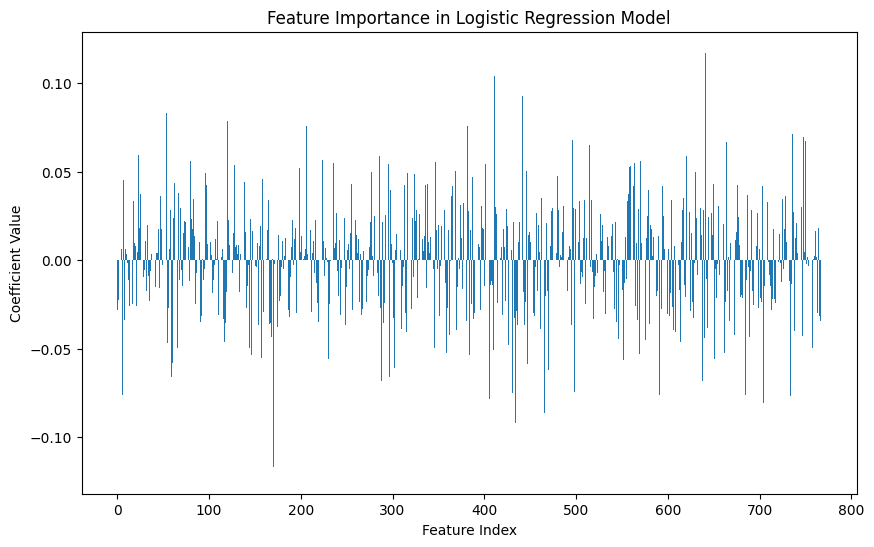

In [40]:
# Get the coefficients from the trained model
best_lr = grid_lr.best_estimator_
feature_importance = best_lr.coef_[0]

# Print the feature importance
print("Feature Importance:\n", feature_importance)

plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), feature_importance)
plt.xlabel("Feature Index")
plt.ylabel("Coefficient Value")
plt.title("Feature Importance in Logistic Regression Model")
plt.show()

In [83]:
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import shap

# Assuming X_train and X_test are your training and test set embeddings
# Assuming best_lr is your trained logistic regression model
# Assuming test_df contains your original test data with cleaned text

# Generate SHAP values
explainer = shap.LinearExplainer(best_lr, X_train)
shap_values = explainer.shap_values(X_test)

# Get the top contributing features for the first test instance
first_test_index = 0  # Assuming this is the index of the first test instance in the DataFrame
first_test_shap_values = shap_values[first_test_index]
top_indices = np.argsort(-np.abs(first_test_shap_values))[:20]

# Extract the original sentence from df for the first test instance
sentence = test_df['cleaned_text'].iloc[first_test_index]
print("Original Sentence:", sentence)

# Segment the sentence into words
segments = sentence.split()

# Load the SentenceTransformer model
model = SentenceTransformer('paraphrase-mpnet-base-v2')

# Compute embeddings for the sentence segments
segment_embeddings = model.encode(segments)
print("Segment Embeddings Shape:", segment_embeddings.shape)

# Since the SHAP values are for the sentence-level embedding, we'll compute the contribution of each word
word_contributions = []
for word_embedding in segment_embeddings:
    word_shap_value = cosine_similarity(word_embedding.reshape(1, -1), first_test_shap_values.reshape(1, -1))[0][0]
    word_contributions.append(word_shap_value)

# Get the top contributing words based on their SHAP values
top_word_indices = np.argsort(-np.abs(word_contributions))[:20]
top_words = [segments[idx] for idx in top_word_indices]

# Preserve the original order of the top contributing words
top_words_in_order = [word for word in segments if word in top_words]

# Reconstruct the sentence using only the top contributing words
top_sentence = ' '.join(top_words_in_order)
print("\nTop contributing sentence reconstructed from top contributing words:")
print(top_sentence)

Original Sentence: complains that  insurance  declined his claim for lost mobile ph he also unhappy with how it handled the claim all references to  include its agents took out his mobile ph insurance policy on it provided cover if the d ph was lost lost his ph in so made claim on his policy he was told the policy had been validated but does agree he says he provided images of his ph to  within seven days of taking out the policy says he had no correspondence from  to suggest him there was any outstanding information and that the policy had been validated he says the payments for the policy have continued to be taken out each month in trying to deal with the matter spent of hours on the ph to  and when he did get through to some he was put on hold and passed around three different departments asked for evidence  had tried to contact him regarding validating his policy but n was provided  said if it had received the information it requested the policy would have been validated it said i

In [85]:
print(test_df['complaint_section'].iloc[0])

The complaint
Mr F complains that Astrenska Insurance Limited (“Astrenska”) declined his claim for a lost 
mobile phone. He’s also unhappy with how it handled the claim. 
All references to Astrenska include its agents. 



In [84]:
print(sentence)

complains that  insurance  declined his claim for lost mobile ph he also unhappy with how it handled the claim all references to  include its agents took out his mobile ph insurance policy on it provided cover if the d ph was lost lost his ph in so made claim on his policy he was told the policy had been validated but does agree he says he provided images of his ph to  within seven days of taking out the policy says he had no correspondence from  to suggest him there was any outstanding information and that the policy had been validated he says the payments for the policy have continued to be taken out each month in trying to deal with the matter spent of hours on the ph to  and when he did get through to some he was put on hold and passed around three different departments asked for evidence  had tried to contact him regarding validating his policy but n was provided  said if it had received the information it requested the policy would have been validated it said it is evident it did

In [44]:
# Generate SHAP values
explainer = shap.LinearExplainer(best_lr, X_train)
shap_values = explainer.shap_values(X_test)

# Get the top contributing features for the first test instance
top_indices = np.argsort(-np.abs(shap_values[0]))[:15]

print("Top contributing features for the first test instance:")
for idx in top_indices:
    print(f"Feature {idx}: SHAP value = {shap_values[0][idx]}")


Top contributing features for the first test instance:
Feature 331: SHAP value = -0.02163939926395915
Feature 434: SHAP value = -0.01444323601290652
Feature 513: SHAP value = -0.011954639892292902
Feature 258: SHAP value = -0.011706697229486194
Feature 170: SHAP value = 0.011440062201472291
Feature 736: SHAP value = -0.011192779202170959
Feature 54: SHAP value = -0.010570033721843472
Feature 411: SHAP value = 0.010019274498465904
Feature 515: SHAP value = -0.00973239813590819
Feature 235: SHAP value = -0.009090536245022054
Feature 346: SHAP value = 0.008783590416780547
Feature 224: SHAP value = -0.008593358968840906
Feature 537: SHAP value = -0.008556204765095079
Feature 465: SHAP value = 0.008511157770882188
Feature 317: SHAP value = 0.00837056874499509


In [45]:
shap_values.shape

(75, 768)

In [70]:
# Select the first test instance and its SHAP values
first_test_index = 0  # Assuming this is the index of the first test instance in the DataFrame
first_test_shap_values = shap_values[first_test_index]

print("Top contributing features for the first test instance:")
for idx in top_indices:
    print(f"Feature {idx}: SHAP value = {first_test_shap_values[idx]}")

# Extract the original sentence from df for the first test instance
sentence = test_df['cleaned_text'].iloc[first_test_index]

# Load the SentenceTransformer model
model = SentenceTransformer('paraphrase-mpnet-base-v2')

# Compute embeddings for the sentence segments
sentence_embeddings = model.encode(sentence)

Top contributing features for the first test instance:
Feature 331: SHAP value = -0.02163939926395915
Feature 434: SHAP value = -0.01444323601290652
Feature 513: SHAP value = -0.011954639892292902
Feature 258: SHAP value = -0.011706697229486194
Feature 170: SHAP value = 0.011440062201472291
Feature 736: SHAP value = -0.011192779202170959
Feature 54: SHAP value = -0.010570033721843472
Feature 411: SHAP value = 0.010019274498465904
Feature 515: SHAP value = -0.00973239813590819
Feature 235: SHAP value = -0.009090536245022054
Feature 346: SHAP value = 0.008783590416780547
Feature 224: SHAP value = -0.008593358968840906
Feature 537: SHAP value = -0.008556204765095079
Feature 465: SHAP value = 0.008511157770882188
Feature 317: SHAP value = 0.00837056874499509


In [81]:
sentence_embeddings[328 : 332]

array([ 0.12253027, -0.029498  , -0.0140861 ,  0.24072748], dtype=float32)

In [73]:
feature_contributions.shape

(1, 1)

In [74]:
sentence_embeddings.shape

(768,)

In [77]:
# Use the entire SHAP vector for comparison
feature_contributions = first_test_shap_values.reshape(1, -1)
print("Feature Contributions Shape:", feature_contributions.shape)

# Compute cosine similarity between the SHAP contribution vector and the sentence embedding
similarities = cosine_similarity(feature_contributions, sentence_embeddings.reshape(1, -1))
print(f"Similarity score: {similarities[0, 0]}")

# Get the top contributing words based on cosine similarity
top_word_indices = np.argsort(-similarities[0])[:20]
print("Top contributing words indices:", top_word_indices)

# Reconstruct the sentence using only the top contributing words, preserving the original order
top_words = [segments[idx] for idx in sorted(top_word_indices)]
top_sentence = ' '.join(top_words)
print("\nTop contributing sentence reconstructed from top contributing words:")
print(top_sentence)

Feature Contributions Shape: (1, 768)
Similarity score: -0.021611508813342468
Top contributing words indices: [0]

Top contributing sentence reconstructed from top contributing words:
complains


In [78]:
similarities

array([[-0.02161151]])

### 3. Exploratory Data Analysis (EDA)
Apply a range of statistical and other modelling techniques to
uncover patterns, trends and correlations within the dataset.

In [38]:
# Check for NA values in the DataFrame
na_values = df.isna().sum()

# Print the number of NA values for each column
print(na_values)

filename                        0
original_text                   0
complaint_section               0
main_reason                     2
complaint_and_what_happened     0
decision                        0
company                         0
clean_complaint                 0
product_type                    0
clean_complain_n_what_happen    0
cleaned_text                    2
dtype: int64


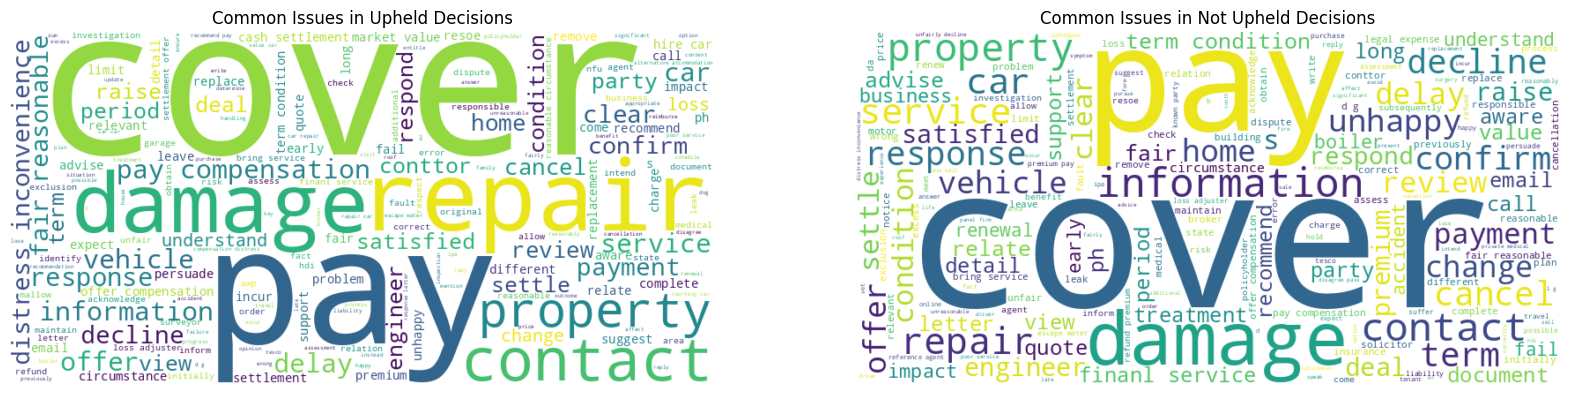

In [39]:
# Explore common words that lead to decisions
def explore_common_word(df):
    # Identify common issues in upheld decisions
    upheld_issues = df[df['decision'] == 'Upheld']['cleaned_text'].dropna()
    wordcloud_upheld = WordCloud(width=800, height=400, background_color='white').generate(' '.join(upheld_issues))

    # Identify common issues in not upheld decisions
    not_upheld_issues = df[df['decision'] == 'Not upheld']['cleaned_text'].dropna()
    wordcloud_not_upheld = WordCloud(width=800, height=400, background_color='white').generate(' '.join(not_upheld_issues))

    plt.figure(figsize=(20, 10))

    plt.subplot(1, 2, 1)
    plt.imshow(wordcloud_upheld, interpolation='bilinear')
    plt.title('Common Issues in Upheld Decisions')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(wordcloud_not_upheld, interpolation='bilinear')
    plt.title('Common Issues in Not Upheld Decisions')
    plt.axis('off')
    plt.show()

explore_common_word(df)

**Product Type**

product_type
car                        1090
others                      886
travel                      285
health                      271
Unknown                     201
life                        155
pet                         142
legal expenses              134
income                       64
business                     63
property                     60
boiler                       46
buildings                    39
emergency                    24
ppi                          14
machine and electronics       6
wedding                       1
Name: count, dtype: int64


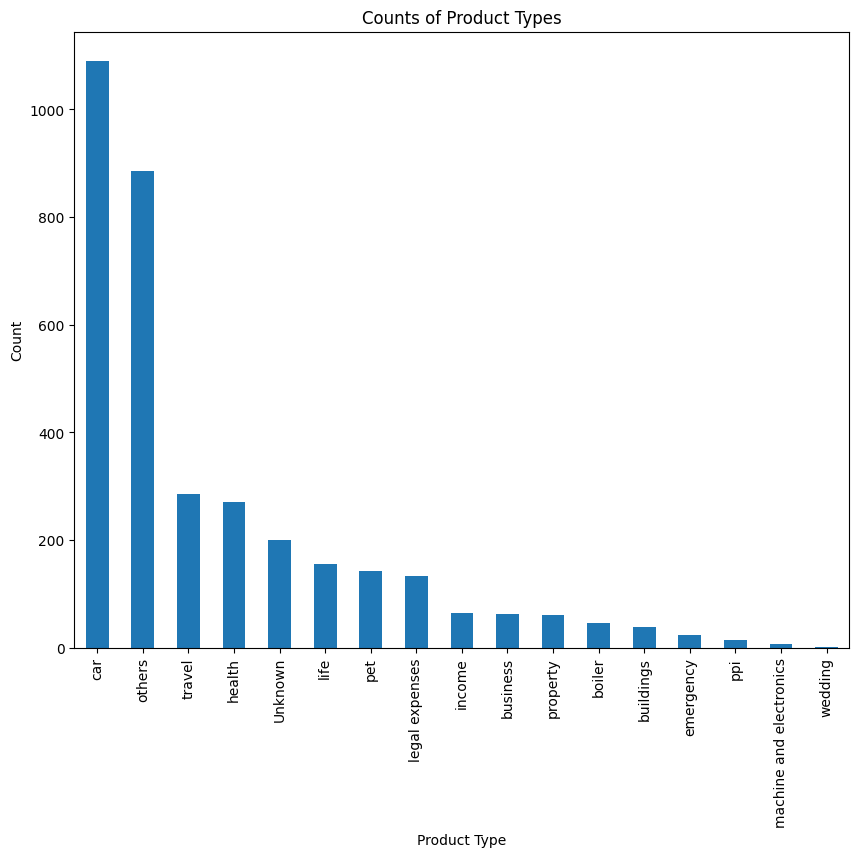

Chi-square test statistic: 124.34235759260315
P-value: 7.998540913535299e-19


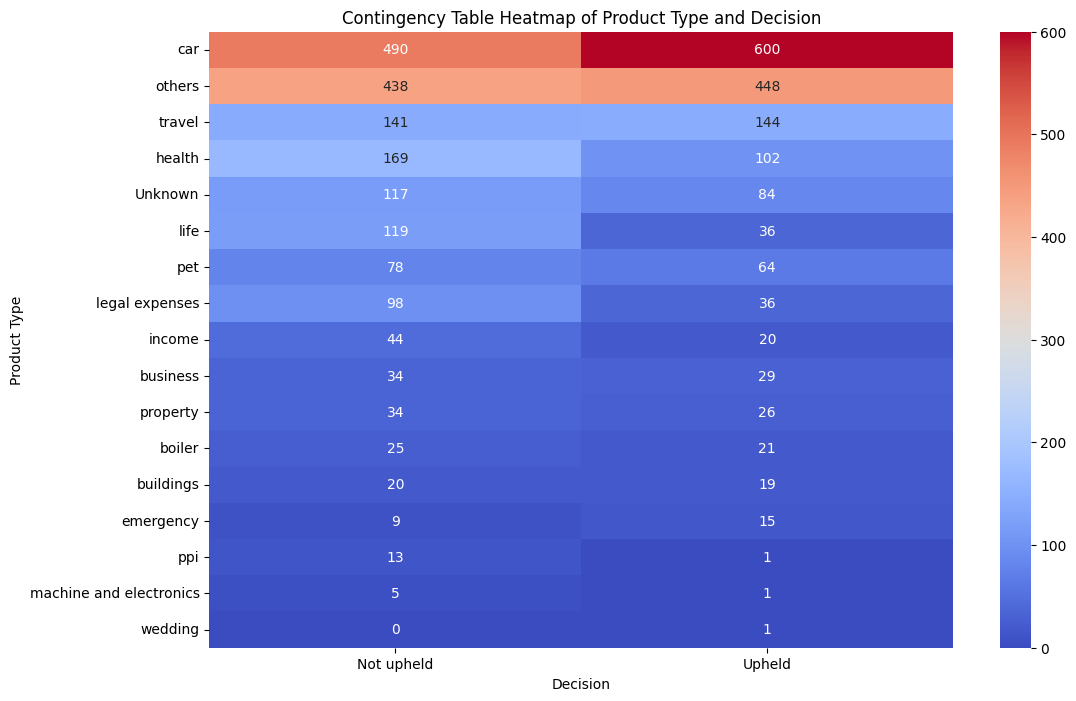

In [41]:
from scipy.stats import chi2_contingency

# Assuming your DataFrame is already defined as df and has 'product_type' and 'decision' columns

# Create a contingency table
contingency_table = pd.crosstab(df['product_type'], df['decision'])

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square test statistic: {chi2}")
print(f"P-value: {p}")

# If p-value < 0.05, there is a significant association between product type and decision

# Sort the table by the total of upheld and not upheld decisions
contingency_table['total'] = contingency_table.sum(axis=1)
contingency_table = contingency_table.sort_values(by='total', ascending=False).drop('total', axis=1)
# Plotting the heatmap of the contingency table
plt.figure(figsize=(12, 8))
sns.heatmap(contingency_table, annot=True, cmap='coolwarm', fmt='d')
plt.title('Contingency Table Heatmap of Product Type and Decision')
plt.xlabel('Decision')
plt.ylabel('Product Type')
plt.show()

#### **Interpretation**

**Chi-Square Test and P-value :**

Chi-square test measures how much the observed counts in the contingency table deviate from the expected counts under the null hypothesis of no association. A higher value indicates a greater difference between the observed and expected counts.

The p-value represents the probability of obtaining a chi-square statistic as extreme as, or more extreme than, the observed value under the null hypothesis.
In this case, the p-value is extremely small (essentially zero). This indicates that there is a very low probability that the observed association between product type and decision occurred by chance.

Since the p-value is much smaller than the conventional significance level (e.g., 0.05), we reject the null hypothesis. This means there is a statistically significant association between the product type and the decision outcome (upheld or not upheld)

**Contingency Table**

The analysis reveals that car and property insurance are the most disputed product types, indicating these areas might benefit from improved claims handling processes and clearer policy documentation.
Health and travel insurance also show a significant number of disputes, suggesting these products might need better customer communication and clearer policy terms.
The presence of unknown product types indicates a need for enhanced data processing to ensure all claims are accurately categorized.

**Next to do**
I will keep the words containing all product types like car, home, etc in the features to predict the decision.

**Compensation Amount**

In [80]:
# Apply extraction functions to the DataFrame
df['compensation'] = df['original_text'].apply(extract_compensation)

The average compensation across all companies is: £3728.16


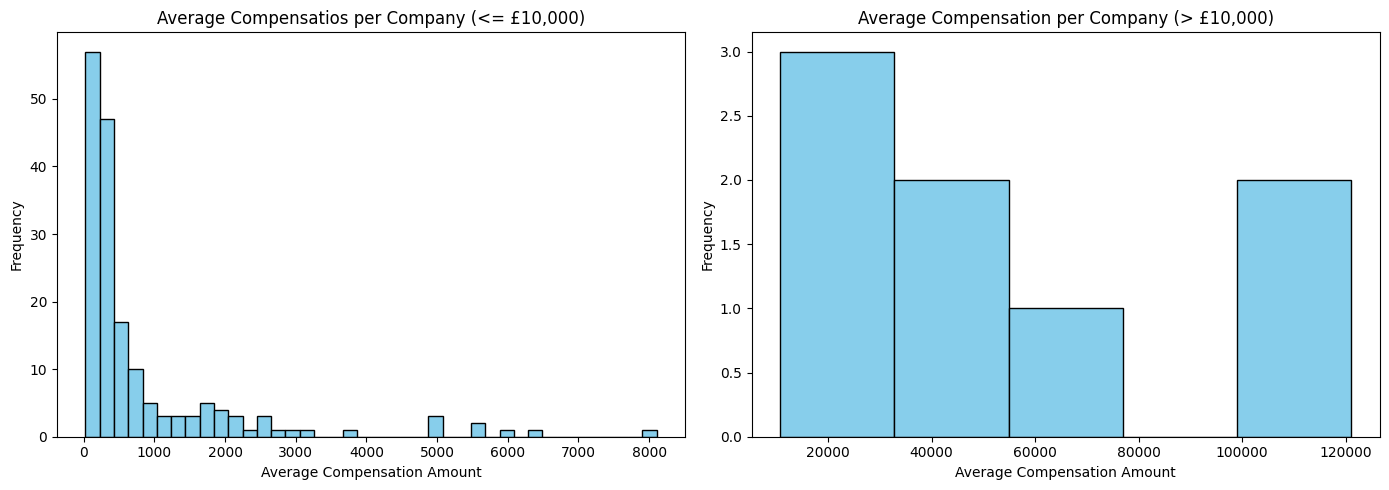

In [81]:
# Function to clean the compensation column
def clean_compensation(comp):
    if isinstance(comp, str):
        # Remove the pound symbol and commas, then strip any whitespace
        comp = comp.replace('£', '').replace(',', '').strip()
        # If the result is empty, replace it with '0'
        if comp == '':
            return 0.0
        # Convert to float
        try:
            return float(comp)
        except ValueError:
            return 0.0
    elif comp is None:
        return 0.0
    return float(comp)

# Apply the cleaning function to the compensation column
df['compensation'] = df['compensation'].apply(clean_compensation)

# Exclude zero compensation amounts
df_nonzero = df[df['compensation'] > 0]

# Calculate the average compensation across all companies
average_compensation_all = df_nonzero['compensation'].mean()

# Display the average compensation
print(f"The average compensation across all companies is: £{average_compensation_all:.2f}")

# Group by company and calculate total and average compensation
company_compensation = df_nonzero.groupby('company')['compensation'].agg(['sum', 'mean', 'count']).reset_index()
company_compensation.columns = ['company', 'total', 'avg', 'count']
company_compensation = company_compensation.sort_values(by='total', ascending=False)

# Split the data into two groups: below and above the threshold
threshold = 10000
below_threshold = company_compensation[company_compensation['avg'] <= threshold]
above_threshold = company_compensation[company_compensation['avg'] > threshold]

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# Plot the histogram of average compensation amounts below the threshold
axes[0].hist(below_threshold['avg'], bins=40, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Average Compensation Amount')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Average Compensatios per Company (<= £10,000)')

# Plot the histogram of average compensation amounts above the threshold
axes[1].hist(above_threshold['avg'], bins=5, color='skyblue', edgecolor='black')
axes[1].set_xlabel('Average Compensation Amount')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Average Compensation per Company (> £10,000)')

# Adjust layout
plt.tight_layout()
plt.show()


In [82]:
# Filter companies with average compensation above the threshold
extreme_companies = company_compensation[company_compensation['avg'] > threshold]

# Filter companies with average compensation above the threshold
not_extreme_companies = company_compensation[company_compensation['avg'] <= threshold]

# Display the companies with extreme compensation amounts
print(f' company with extreme compensation amount : ')
print(extreme_companies)

 company with extreme compensation amount : 
                                  company       total            avg  count
62                                  Covea  1131209.08   43508.041538     26
30                                   Arch   748062.72  106866.102857      7
84                                    HCC   484429.72  121107.430000      4
3                         AA Underwriting   182632.66   10743.097647     17
161                        The Prudential   127452.42   42484.140000      3
69   ERGO Versicherung Aktiengesellschaft   124718.00   62359.000000      2
76                                Factory    50250.00   25125.000000      2
132                              ReAssure    37794.00   12598.000000      3


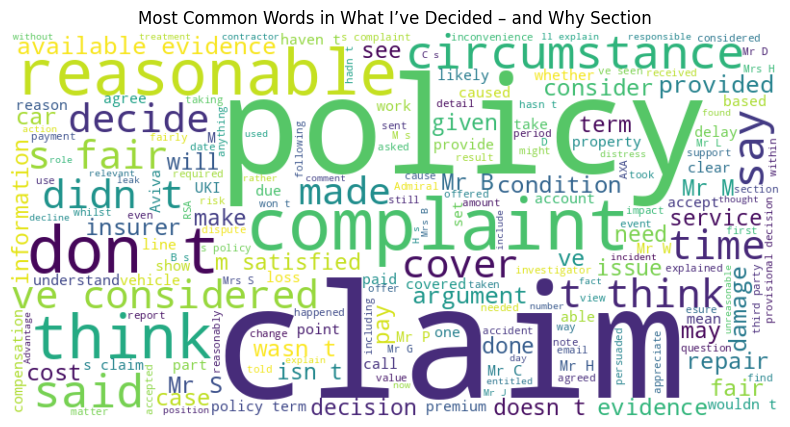

In [83]:
def extract_what_decided_and_why_section(text):
    # Define the pattern to locate the "What I've decided – and why" section
    decided_pattern = re.compile(r"What I(?:’|')ve decided\s*–\s*and why(.*?)(My final decision|The investigator(?:’|')s view|Putting things right|Other section|Another pattern)", re.DOTALL)
    
    # Extract the "What I've decided – and why" section
    decided_match = decided_pattern.search(text)
    decided_section = decided_match.group(1).strip() if decided_match else ''
    
    return decided_section

# Apply extraction function to the DataFrame
df['what_decided_and_why_section'] = df['original_text'].apply(extract_what_decided_and_why_section)
# Clean the extracted section
#df['cleaned_what_decided_and_why_section'] = df['what_decided_and_why_section'].apply(clean_text)

# Generate word cloud
generate_word_cloud(' '.join(df['what_decided_and_why_section'].dropna()), 'Most Common Words in What I’ve Decided – and Why Section')

### 4. Visualization of Trends
This involves visualisation of data distributions, outlier
identification, and other interesting insights coming from the dataset

decision
Not upheld    1834
Upheld        1647
Name: count, dtype: int64


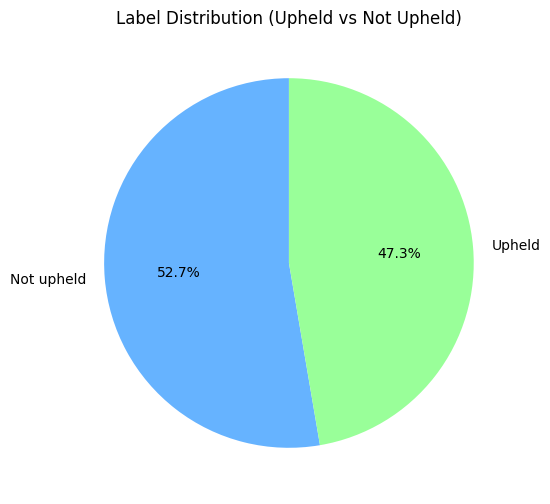

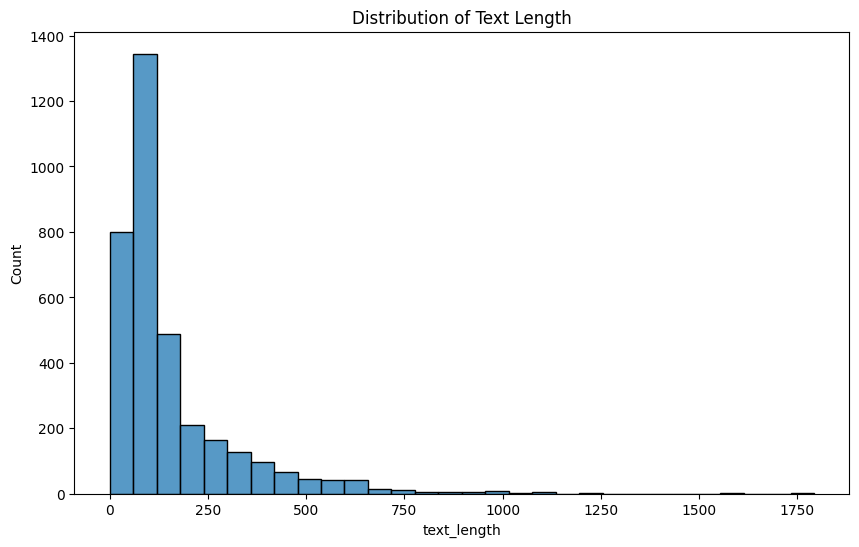

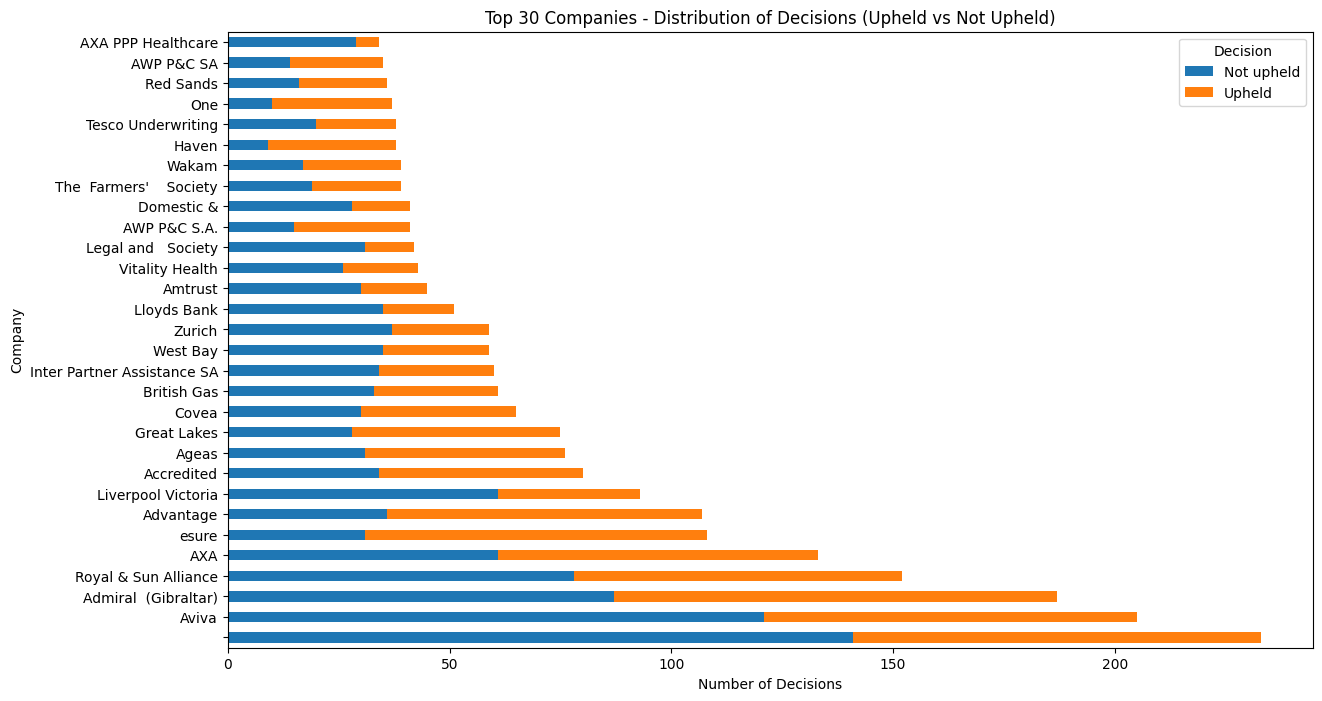

In [84]:
# Basic statistics
print(df['decision'].value_counts())

# Visualize the label distribution with a pie chart
plt.figure(figsize=(8, 6))
df['decision'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#99ff99'])
plt.title('Label Distribution (Upheld vs Not Upheld)')
plt.ylabel('')  # Hide the y-label for better appearance
plt.show()

# Length of text analysis
df['cleaned_text'] = df['cleaned_text'].fillna('')
df['text_length'] = df['cleaned_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=30)
plt.title('Distribution of Text Length')
plt.show()

# Aggregate decision counts by company
company_decision_counts = df.groupby(['company', 'decision']).size().unstack().fillna(0)

# Select the top 30 companies based on the total number of decisions
top_30_companies = company_decision_counts.sum(axis=1).nlargest(30).index
top_30_decision_counts = company_decision_counts.loc[top_30_companies]

# Plot stacked horizontal bar chart
top_30_decision_counts.plot(kind='barh', stacked=True, figsize=(14, 8))

plt.ylabel('Company')
plt.xlabel('Number of Decisions')
plt.title('Top 30 Companies - Distribution of Decisions (Upheld vs Not Upheld)')
plt.legend(title='Decision', loc='upper right')
plt.show()

In [85]:


# Assuming df is your DataFrame and it has the columns 'company' and 'decision'

# Convert the decision column to binary values
df['decision_binary'] = df['decision'].apply(lambda x: 1 if x == 'Upheld' else 0)

# One-hot encode the company column
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
company_encoded = encoder.fit_transform(df[['company']])

# Create a DataFrame for the encoded company data
company_encoded_df = pd.DataFrame(company_encoded, columns=encoder.get_feature_names_out(['company']))

# Add the decision_binary column to the encoded company DataFrame
company_encoded_df['decision_binary'] = df['decision_binary'].values

# Compute the correlation matrix
correlation_matrix = company_encoded_df.corr()

# Extract the correlations with the decision_binary column
correlations_with_decision = correlation_matrix['decision_binary'].drop('decision_binary')

# Sort the correlations to see the most and least correlated companies
sorted_correlations = correlations_with_decision.sort_values(ascending=False)

# Display the top correlated companies
print("Top correlated companies with decision outcome (upheld):")
print(sorted_correlations.head(10))

# Display the bottom correlated companies
print("\nLeast correlated companies with decision outcome (upheld):")
print(sorted_correlations.tail(10))

Top correlated companies with decision outcome (upheld):
company_esure          0.085951
company_Marshmallow    0.071493
company_Advantage      0.067916
company_Haven          0.061025
company_QIC            0.059442
company_One            0.053268
company_Great Lakes    0.045630
company_Casualty &     0.043990
company_Bastion        0.040022
company_Euroins AD     0.037681
Name: decision_binary, dtype: float64

Least correlated companies with decision outcome (upheld):
company_                      -0.041999
company_AIG Life              -0.042538
company_Barclays Bank         -0.042538
company_Liverpool Victoria    -0.042825
company_Pinnacle              -0.043104
company_Unum                  -0.044255
company_DAS Legal Expenses    -0.046687
company_Legal and   Society   -0.046755
company_BUPA                  -0.049200
company_AXA PPP Healthcare    -0.064864
Name: decision_binary, dtype: float64


Note : The correlation values are relatively low, indicating a weak but noticeable trend. Therefore, I will not include the company name in the features.

### 6. Prediction of Claim Outcome with Hyperparameter Tuning

#### A. Logistic Regression Model

In [91]:
# Hyperparameter tuning for Logistic Regression
param_grid_lr = {'C': [2, 3, 4, 5, 6, 7, 10]}
grid_lr = GridSearchCV(LogisticRegression(max_iter=2000), param_grid_lr, refit=True, verbose=2)
grid_lr.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] END ................................................C=2; total time=   0.0s
[CV] END ................................................C=2; total time=   0.0s
[CV] END ................................................C=2; total time=   0.0s
[CV] END ................................................C=2; total time=   0.0s
[CV] END ................................................C=2; total time=   0.0s
[CV] END ................................................C=3; total time=   0.0s
[CV] END ................................................C=3; total time=   0.0s
[CV] END ................................................C=3; total time=   0.0s
[CV] END ................................................C=3; total time=   0.0s
[CV] END ................................................C=3; total time=   0.0s
[CV] END ................................................C=4; total time=   0.0s
[CV] END ........................................

GridSearchCV(estimator=LogisticRegression(max_iter=2000),
             param_grid={'C': [2, 3, 4, 5, 6, 7, 10]}, verbose=2)

In [92]:
# Best parameters from GridSearchCV for Logistic Regression
print("Best parameters for Logistic Regression:", grid_lr.best_params_)

# Predictions and evaluation for Logistic Regression
y_pred_lr = grid_lr.predict(X_test)
print("Logistic Regression Classifier (TF-IDF):")
print(classification_report(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))

Best parameters for Logistic Regression: {'C': 3}
Logistic Regression Classifier (TF-IDF):
              precision    recall  f1-score   support

  Not upheld       0.72      0.74      0.73       361
      Upheld       0.71      0.69      0.70       336

    accuracy                           0.71       697
   macro avg       0.71      0.71      0.71       697
weighted avg       0.71      0.71      0.71       697

[[266  95]
 [105 231]]


#### B. Decision Tree Model

In [101]:
# Hyperparameter tuning for Decision Tree
param_grid_dt = {'criterion': ['gini', 'entropy'], 'max_depth': [2, 3, 5, 7, 10], 'min_samples_split': [2 ,3, 5, 7, 10, 12]}
grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, refit=True, verbose=2)
grid_dt.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END ...criterion=gini, max_depth=2, min_samples_split=2; total time=   0.0s
[CV] END ...criterion=gini, max_depth=2, min_samples_split=2; total time=   0.0s
[CV] END ...criterion=gini, max_depth=2, min_samples_split=2; total time=   0.0s
[CV] END ...criterion=gini, max_depth=2, min_samples_split=2; total time=   0.0s
[CV] END ...criterion=gini, max_depth=2, min_samples_split=2; total time=   0.0s
[CV] END ...criterion=gini, max_depth=2, min_samples_split=3; total time=   0.1s
[CV] END ...criterion=gini, max_depth=2, min_samples_split=3; total time=   0.0s
[CV] END ...criterion=gini, max_depth=2, min_samples_split=3; total time=   0.0s
[CV] END ...criterion=gini, max_depth=2, min_samples_split=3; total time=   0.0s
[CV] END ...criterion=gini, max_depth=2, min_samples_split=3; total time=   0.0s
[CV] END ...criterion=gini, max_depth=2, min_samples_split=5; total time=   0.0s
[CV] END ...criterion=gini, max_depth=2, min_sa

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 7, 10],
                         'min_samples_split': [2, 3, 5, 7, 10, 12]},
             verbose=2)

In [102]:
# Best parameters from GridSearchCV for Decision Tree
print("Best parameters for Decision Tree:", grid_dt.best_params_)

# Predictions and evaluation for Decision Tree
y_pred_dt = grid_dt.predict(X_test)
print("Decision Tree Classifier (TF-IDF):")
print(classification_report(y_test, y_pred_dt))
print(confusion_matrix(y_test, y_pred_dt))

Best parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 3}
Decision Tree Classifier (TF-IDF):
              precision    recall  f1-score   support

  Not upheld       0.75      0.69      0.72       361
      Upheld       0.69      0.75      0.72       336

    accuracy                           0.72       697
   macro avg       0.72      0.72      0.72       697
weighted avg       0.72      0.72      0.72       697

[[248 113]
 [ 83 253]]


#### C. Random Forest Model

In [99]:
# Hyperparameter tuning for Random Forest
param_grid_rf = {'n_estimators': [250, 300, 350], 'max_features': ['sqrt']}
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, refit=True, verbose=2)
grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ................max_features=sqrt, n_estimators=250; total time=   3.6s
[CV] END ................max_features=sqrt, n_estimators=250; total time=   3.6s
[CV] END ................max_features=sqrt, n_estimators=250; total time=   3.7s
[CV] END ................max_features=sqrt, n_estimators=250; total time=   3.6s
[CV] END ................max_features=sqrt, n_estimators=250; total time=   3.6s
[CV] END ................max_features=sqrt, n_estimators=300; total time=   4.3s
[CV] END ................max_features=sqrt, n_estimators=300; total time=   5.6s
[CV] END ................max_features=sqrt, n_estimators=300; total time=   5.5s
[CV] END ................max_features=sqrt, n_estimators=300; total time=   5.4s
[CV] END ................max_features=sqrt, n_estimators=300; total time=   5.3s
[CV] END ................max_features=sqrt, n_estimators=350; total time=   5.2s
[CV] END ................max_features=sqrt, n_est

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_features': ['sqrt'],
                         'n_estimators': [250, 300, 350]},
             verbose=2)

In [100]:
# Best parameters from GridSearchCV for Random Forest
print("Best parameters for Random Forest:", grid_rf.best_params_)

# Predictions and evaluation for Random Forest
y_pred_rf = grid_rf.predict(X_test)
print("Random Forest Classifier (TF-IDF):")
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

Best parameters for Random Forest: {'max_features': 'sqrt', 'n_estimators': 300}
Random Forest Classifier (TF-IDF):
              precision    recall  f1-score   support

  Not upheld       0.78      0.75      0.77       361
      Upheld       0.74      0.77      0.76       336

    accuracy                           0.76       697
   macro avg       0.76      0.76      0.76       697
weighted avg       0.76      0.76      0.76       697

[[272  89]
 [ 78 258]]


### 7. Feature Importance

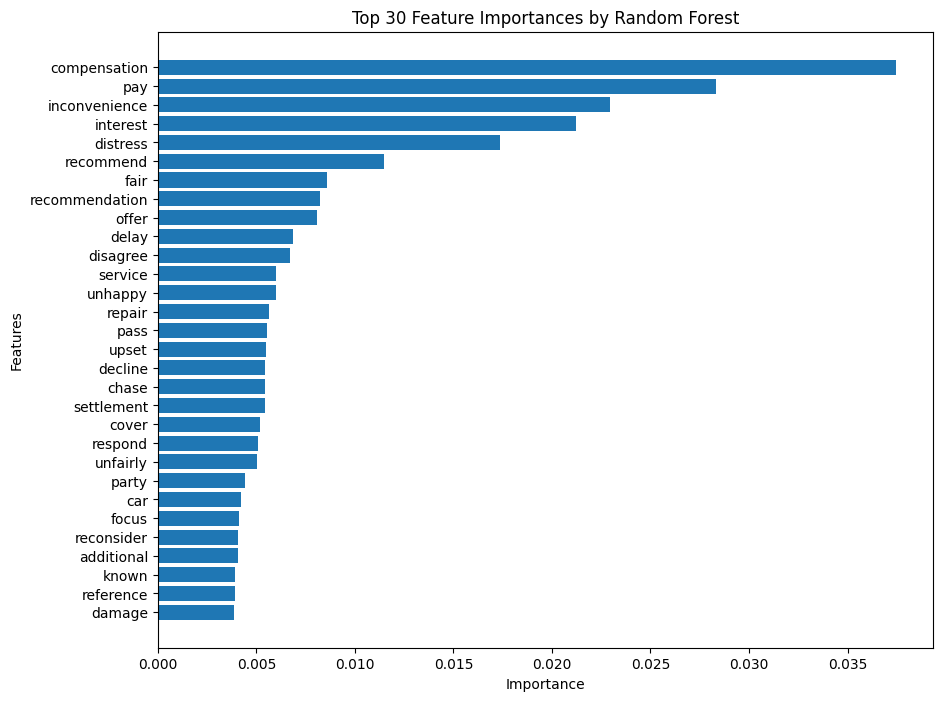

In [104]:
# Assuming the feature importance plot data is available
importances = grid_rf.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
features = vectorizer.get_feature_names_out()

# Get top 20 features
top_features = [features[i] for i in indices[:30]]
top_importances = [importances[i] for i in indices[:30]]

# Create a DataFrame to map features and their importances
feature_importance_df = pd.DataFrame({
    'Feature': top_features,
    'Importance': top_importances
})

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.title("Top 30 Feature Importances by Random Forest")
plt.barh(range(len(top_features)), top_importances, align="center")
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.gca().invert_yaxis()  # To display the highest importance feature at the top
plt.show()

In [103]:
def get_synonym_group(word):
    synonyms = set()
    for syn in wn.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name().lower())
    return synonyms

def group_features_by_synonyms(features):
    grouped_features = {}
    for feature in features:
        synonyms = get_synonym_group(feature)
        found_group = False
        for group in grouped_features:
            if not synonyms.isdisjoint(grouped_features[group]):
                grouped_features[group].update(synonyms)
                grouped_features[group].add(feature)
                found_group = True
                break
        if not found_group:
            grouped_features[feature] = synonyms
            grouped_features[feature].add(feature)
    return grouped_features

# Assuming the feature importance plot data is available
importances = grid_rf.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
features = vectorizer.get_feature_names_out()

# Get top 20 features
top_features = [features[i] for i in indices[:30]]

# Group features by synonyms
grouped_features = group_features_by_synonyms(top_features)

# Print grouped features
for key, value in grouped_features.items():
    print(f"{key}: {', '.join(value)}")

compensation: fixing, continue, shroud, remediate, reanimate, hide, character_reference, animate, extend, blanket, haunt, report, concealment, resort, renovate, character, covering, rectify, doctor, get_across, quicken, natural_covering, computer_address, insure, overlay, deal, amend, address, quotation, plow, cover_up, compensation, hangout, remedy, cover_song, treat, cut_through, book_of_facts, spread_over, traverse, hatch, recreate, pass_over, breed, citation, screening, touch_on, encompass, acknowledgment, consultation, source, incubate, credit, masking, reparation, compensate, revive, denotation, book_binding, overcompensate, brood, reference_point, cite, back, indemnify, binding, fix, stamping_ground, cover, covert, comprehend, enshroud, reference, track, revivify, restore, furbish_up, bushel, cut_across, mend, handle, cover_version, reference_work, point_of_reference, cross, extension, wrap_up, mention, reference_book, top, screen, cover_charge, get_over, recompense, mending, un

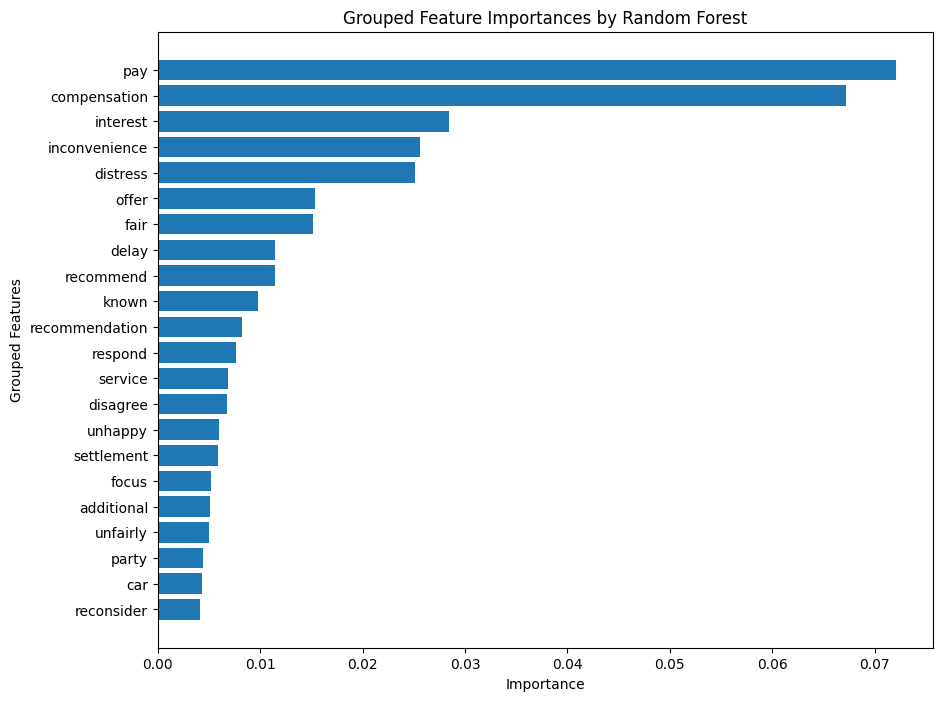

In [105]:
# Aggregate importances for grouped features
grouped_importances = defaultdict(float)
for feature, synonyms in grouped_features.items():
    for synonym in synonyms:
        if synonym in features:
            idx = list(features).index(synonym)
            grouped_importances[feature] += importances[idx]

# Sort grouped features by their aggregated importance
sorted_grouped_importances = sorted(grouped_importances.items(), key=lambda x: x[1], reverse=True)

# Plot grouped feature importances
plt.figure(figsize=(10, 8))
plt.title("Grouped Feature Importances by Random Forest")
plt.barh(range(len(sorted_grouped_importances)), [importance for _, importance in sorted_grouped_importances], align="center")
plt.yticks(range(len(sorted_grouped_importances)), [feature for feature, _ in sorted_grouped_importances])
plt.xlabel('Importance')
plt.ylabel('Grouped Features')
plt.gca().invert_yaxis()  # To display the highest importance feature at the top
plt.show()


>> to do : Analyze Feature Importance for Decision Making

**Guide Decision Making on Products**

/tmp/ipykernel_93500/1947693130.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Product Type', data=product_type_importance_df, palette='viridis')


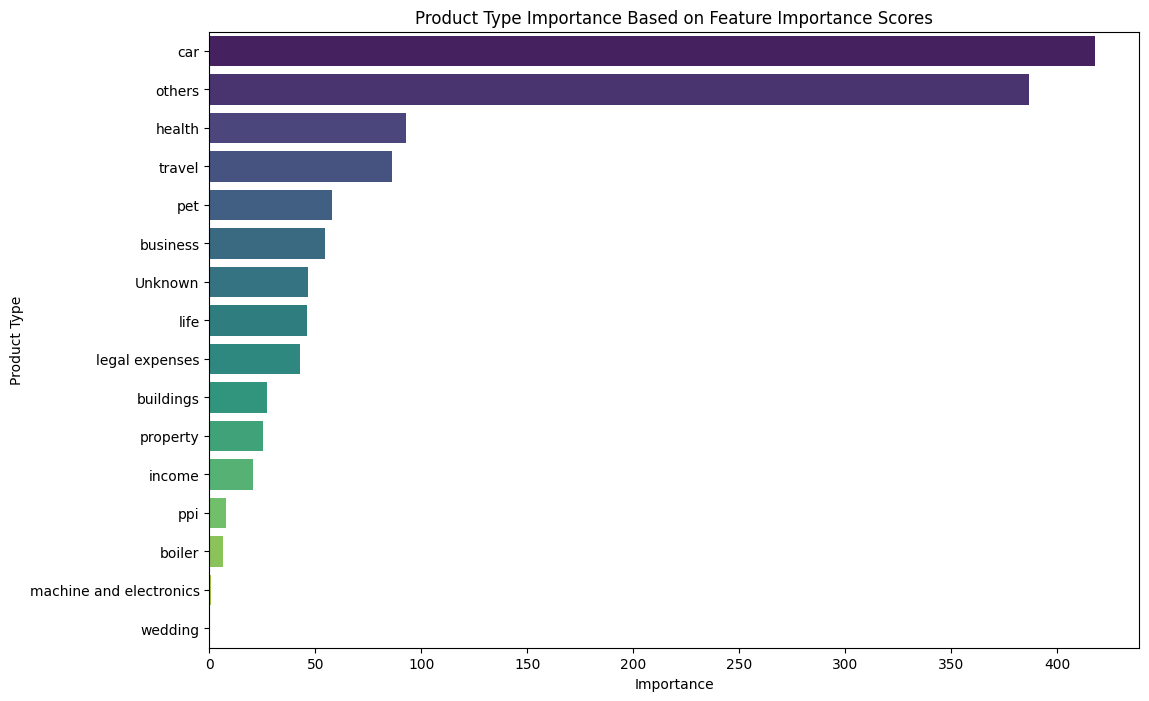

In [106]:
# Assuming the Random Forest model and vectorizer are already trained
importances = grid_rf.best_estimator_.feature_importances_
features = vectorizer.get_feature_names_out()

# Get the feature importance dictionary
feature_importance_dict = dict(zip(features, importances))

# Function to calculate weighted product type importance
def calculate_product_type_importance(df, feature_importance_dict):
    product_type_importance = defaultdict(float)
    for idx, row in df.iterrows():
        product_types = row['product_type'].split(', ')
        cleaned_text = row['cleaned_text']
        for product in product_types:
            for word in cleaned_text.split():
                if word in feature_importance_dict:
                    product_type_importance[product] += feature_importance_dict[word]
    return product_type_importance

# Calculate the importance of each product type
product_type_importance = calculate_product_type_importance(df, feature_importance_dict)

# Convert to DataFrame for plotting
product_type_importance_df = pd.DataFrame(list(product_type_importance.items()), columns=['Product Type', 'Importance'])
product_type_importance_df = product_type_importance_df.sort_values(by='Importance', ascending=False)

# Plot the distribution of product types by importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Product Type', data=product_type_importance_df, palette='viridis')
plt.title('Product Type Importance Based on Feature Importance Scores')
plt.xlabel('Importance')
plt.ylabel('Product Type')
plt.show()


### Interpreting the Product Type Importance Plot

The bar plot titled **"Product Type Importance Based on Feature Importance Scores"** visualizes the relative importance of different product types in influencing the decision outcomes (upheld or not upheld). Here's a step-by-step interpretation:

1. **Overall Importance**: 
   - The plot ranks product types based on their importance scores. The higher the score, the more significant the product type is in determining the decision outcome.
   - The length of each bar represents the cumulative importance score of features associated with each product type.

2. **Top Product Types**:
   - **Car Insurance**: This product type has the highest importance score, suggesting that features associated with car insurance claims significantly impact the decision outcomes. This could indicate a high volume of car insurance-related complaints or more complex cases requiring detailed adjudication.
   - **Property Insurance**: Property insurance follows closely behind car insurance in importance. This suggests that property-related claims also play a significant role in decision outcomes.
   - **Travel Insurance**: Travel insurance is another critical product type influencing decision outcomes. 

3. **Mid-Range Product Types**:
   - **Others, Life, Health, Business, Pet**: These product types have moderate importance scores. While they are not as influential as car or property insurance, they still play a notable role in the decision-making process.
   - **Legal Expenses, Buildings, Income**: These types are important but to a lesser extent compared to the top and mid-range categories.

4. **Lower Importance Product Types**:
   - **Boiler Insurance** and **Machine and Electronics Insurance**: These product types have the lowest importance scores, indicating that they are less frequently involved in decisions or have less complex cases.

### Practical Implications:

1. **Product Development**:
   - **Car Insurance**: Given its high importance, consider enhancing car insurance products, adding features that address common complaints or improving claim handling processes.
   - **Property and Travel Insurance**: Similarly, focus on these areas to innovate and reduce complaint rates.

#### Minimize Future Disputes and Enhance Customer Satisfaction
Predict and prevent potential disputes by addressing issues before they escalate.

In [110]:
# Predict using the Random Forest model
predictions = grid_rf.predict(X)

# Add predictions to the DataFrame
df['predictions'] = predictions

# Analyze predictions for insights
upheld_predictions = df[df['predictions'] == 'Upheld']
not_upheld_predictions = df[df['predictions'] == 'Not upheld']

print("Predictions for Upheld Complaints:", upheld_predictions.shape[0])
print("Predictions for Not Upheld Complaints:", not_upheld_predictions.shape[0])

Predictions for Upheld Complaints: 1657
Predictions for Not Upheld Complaints: 1824


#### Visualize and Communicate Findings
Use visualizations to communicate the key findings to stakeholders.

In [10]:
# Function to generate a word cloud from text data
def generate_wordcloud_from_text(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=50).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Function to generate word clouds for important features based on predictions
def generate_wordclouds_based_on_predictions(df, importances, features):
    # Filter the data based on predictions
    upheld_text = ' '.join(df[df['predictions'] == 'Upheld']['cleaned_text'])
    not_upheld_text = ' '.join(df[df['predictions'] == 'Not upheld']['cleaned_text'])
    
    # Generate word clouds
    generate_wordcloud_from_text(upheld_text, 'Word Cloud of Important Features in Upheld Predictions')
    generate_wordcloud_from_text(not_upheld_text, 'Word Cloud of Important Features in Not Upheld Predictions')

# Assuming `importances` contains the feature importance scores
# and `vectorizer` is the fitted vectorizer used for feature extraction
features = vectorizer.get_feature_names_out()
importances = grid_rf.best_estimator_.feature_importances_

# Generate and plot word clouds for the important features in upheld and not upheld decisions
generate_wordclouds_based_on_predictions(df, importances, features)


NameError: name 'vectorizer' is not defined

### Insights from Word Cloud Analysis

The word clouds provide a visual representation of the most important features leading to upheld and not upheld decisions based on the random forest model's feature importance scores. Here are some key insights:

#### Upheld Predictions:
1. **Dominant Terms**:
   - **Cover**: The term "cover" is prominently featured, indicating that issues related to coverage are significant in decisions being upheld.
   - **Repair**: The term "repair" also appears frequently, suggesting that disputes involving repair claims are crucial.
   - **Pay**: The frequency of the term "pay" indicates that financial compensation is a significant factor in these decisions.
   - **Damage**: The term "damage" is often cited, emphasizing its importance in upheld complaints.

2. **Other Important Terms**:
   - **Service**: Issues related to service quality or service delivery appear to be important.
   - **Delay**: Delays in processing claims or providing services are critical issues.
   - **Fair** and **Reasonable**: Terms related to fairness and reasonableness suggest that these considerations are key in determining the outcomes of complaints.

#### Not Upheld Predictions:
1. **Dominant Terms**:
   - **Information**: The term "information" is very prominent, indicating that issues around information provision or documentation play a significant role in not upheld decisions.
   - **Cover**: Similar to upheld decisions, coverage-related issues are important but might be resolved differently in not upheld cases.
   - **Property**: Property-related issues are also significant in complaints that are not upheld.
   - **Service**: Service-related issues continue to be important but might be deemed insufficient to uphold the complaint.

2. **Other Important Terms**:
   - **Contact**: The term "contact" suggests that communication issues are relevant.
   - **Pay** and **Damage**: Similar to upheld cases, but the context in which these terms are relevant may differ.
   - **Fair** and **Reasonable**: These terms appear again, indicating that perceptions of fairness and reasonableness are evaluated differently in not upheld cases.

### Practical Usage for FOS

#### Guide Decision Making on Product Creation:
- **Focus on Coverage and Repair**: Products that provide clear and comprehensive coverage and address repair issues effectively are likely to reduce disputes.
- **Improve Service and Information Delivery**: Enhancing service quality and ensuring clear, consistent information can help reduce the number of not upheld decisions.

#### Identify Potential Risks with Existing Products:
- **Address Delays**: Delays are a critical factor in complaints. Streamlining processes to minimize delays can mitigate risks.
- **Emphasize Fairness and Reasonableness**: Ensuring that all processes and decisions are perceived as fair and reasonable can help in reducing disputes.

#### Handling of Existing Complaints:
- **Focus on Communication**: Improving communication with customers about their coverage, claims, and the status of their complaints can lead to better outcomes.
- **Detailed Documentation**: Ensuring that all necessary information and documentation are provided can help in resolving disputes more effectively.